Campos de dados
A maioria dos campos é autoexplicativa. A seguir estão as descrições daqueles que não o são.

Id - um Id que representa um duple (Loja, Data) dentro do conjunto de teste

Loja – um ID exclusivo para cada loja

Vendas - o faturamento de um determinado dia (é isso que você está prevendo)

Clientes - o número de clientes em um determinado dia

Aberta - um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta

StateHoliday – indica feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas estão fechadas nos feriados e fins de semana. 

a = feriado, b = feriado de Páscoa, c = Natal, 0 = Nenhum

SchoolHoliday - indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas

StoreType  - diferencia entre 4 modelos de loja diferentes: a, b, c, d

Sortimento - descreve um nível de sortimento: a = básico, b = extra, c = estendido

CompetitionDistance - distância em metros até a loja concorrente mais próxima

CompetitionOpenSince[Month/Year] - fornece o ano e mês aproximados da hora em que o concorrente mais próximo foi aberto

Promoção - indica se uma loja está realizando uma promoção naquele dia

Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não participa, 1 = loja participa


Promo2Since[Ano/Semana] - descreve o ano e a semana do calendário em que a loja começou a participar da Promo2

PromoInterval - descreve os intervalos consecutivos de início da Promo2, nomeando os meses em que a promoção é reiniciada. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada 

rodada começa em fevereiro, maio, agosto e novembro de qualquer ano para aquela loja

# 0.0. IMPORTS

In [1]:
import pickle

import math
import datetime
import inflection

import numpy             as np
import pandas            as pd
import xgboost           as xgb
import seaborn           as sns
import matplotlib.pyplot as plt

from scipy                import stats as ss
from boruta               import BorutaPy
from tabulate             import tabulate
from IPython.display      import Image
from IPython.core.display import HTML

from sklearn               import metrics as mt 
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1. HELPER FUNCTIONS

In [2]:
def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat )
    #mse = mt.mean_squared_error( y, yhat )
    rmse = mt.root_mean_squared_error( y, yhat)

    return pd.DataFrame(  { 'Model Name' : model_name,
                            'MAE' : mae,
                            'MAPE' : mape,
                            'RMSE' : rmse }, index=[0] ) 

def cross_validation(xtraining, kfold, model_name, model, verbose=False):
    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        val_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        val_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dateset
        training = x_training[ x_training['date'] < val_start_date ]
        validation = x_training[ ( x_training['date'] >= val_start_date ) & ( x_training['date'] <= val_end_date ) ]

        # training and validation dateset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model  
        m = model
        m.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each KFold iteration 
        mae_list.append(  m_result['MAE'] ) 
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    # metrica real 
    return pd.DataFrame( {  'Model Name' : model_name,
                            'MAE MEAN' : np.round( np.mean( mae_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ),2 ).astype( str ), 
                            'MAPE MEAN' : np.round( np.mean( mape_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ),2 ).astype( str ),
                            'RMSE MEAN' : np.round( np.mean( rmse_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ),2 ).astype( str ) }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    v = np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )
    return v

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y ) 

#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    sns.set()


## 0.2. LOAD DATASETS

In [3]:
df_sales_raw = pd.read_csv('..//datasets//train.csv', low_memory=False)
df_store_raw = pd.read_csv('..//datasets//store.csv', low_memory=False)

#fulsao
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 1 - DESCRIÇAO DE DADOS

https://www.kaggle.com/c/rossmann-store-sales/data

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
old_cols = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval' ]

snakecase = lambda x: inflection.underscore( x )

new_cols= list( map( snakecase, old_cols ) ) 

#rename
df1.columns = new_cols

## 1.2. data Dimensions

In [7]:
print('Number of rows: {}'.format( df1.shape[0] ))
print('Number of cols: {}'.format( df1.shape[1] ))

Number of rows: 1017209
Number of cols: 18


## 1.3. data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA
### resolvendo linhas com variaveis NAN

In [11]:
# resolvendo coluna por coluna ja que esse coluna ver os competidores mais proximos entao eu vou colocar um valor muito acima do maximo da coluna para demostra que nao a competiçao.
#competition_distance    
print(df1['competition_distance'].max()) 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

75860.0


In [12]:
#competition_open_since_month
# se a coluna 'competition_open_since_month' for nan entao pegue o mes da coluna 'date' e coloque no lugar do nan se nao manteia o mes que ja tem na coluna 'competition_open_since_month'
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

In [13]:
#competition_open_since_year 
# se a coluna 'competition_open_since_year' for nan entao pegue o ano da coluna 'date' e coloque no lugar do nan se nao manteia o ano que ja tem na coluna 'competition_open_since_year'
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

In [14]:
#promo2_since_week
# quando nessa coluna o valor e nan quer dizer que esse coluna nao esta parteicipando da promoçao2 entao eu vou colocar a semana da 'date' da venda para que depois eu possa calcular a quanto 
#tempo essa promoçao esta desativa 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

In [15]:
#promo2_since_year 
# quando nessa coluna o valor e nan quer dizer que esse coluna nao esta parteicipando da promoçao2 entao eu vou colocar o ano da 'date' da venda para que depois eu possa calcular a quanto 
#tempo essa promoçao esta desativa 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

In [16]:
#promo_interval
#
mouth_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }       

df1['promo_interval'].fillna(0, inplace=True)

df1['mouth_map'] = df1['date'].dt.month.map( mouth_map )

#se o 'mouth_map' esta dentro do intervalo do 'promo_interval' retorna 1 ou 0 em uma nova coluna chamada 'is_promo2' 1 mostrando que esta na promoçao e 0 que nao esta
df1['is_promo2'] = df1[['promo_interval', 'mouth_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['mouth_map'] in x['promo_interval'].split( ',' ) else 0 , axis=1)

/tmp/ipykernel_2360/4225278941.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
mouth_map                       0
is_promo2                       0
dtype: int64

## 1.6. chage types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
mouth_map                               object
is_promo2                                int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int ) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int ) 

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
mouth_map                               object
is_promo2                                int64
dtype: object

## 1.7. Decriptive Statiscal

In [20]:
num_atributes = df1.select_dtypes(include=[ 'int64', 'float64' ])
cat_atributes = df1.select_dtypes(exclude=[ 'int64', 'float64', 'datetime64[ns]' ])

### 1.7.1 numerical Attributes

In [21]:
#Central Tendency - mean, median
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_atributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_atributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_atributes.apply( min ) ).T
d3 = pd.DataFrame( num_atributes.apply( max ) ).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [22]:
# Plota o gráfico de distribuição com tamanho personalizado
#sns.distplot(df1['competition_distance'])

In [23]:
#sns.distplot(df1['sales'])

## 1.7.2 A decriçao da tabela

Entendi, peço desculpas pela confusão. Aqui está a descrição em markdown de todos os 14 atributos:

**store:**
- Mínimo (Min): 1.0
- Máximo (Max): 1115.0
- Amplitude (Range): 1114.0
- Média (Mean): 558.429727
- Mediana (Median): 558.0
- Desvio Padrão (Std): 321.908493
- Assimetria (Skew): Praticamente simétrica (valor próximo de zero)
- Curtose (Kurtosis): Levemente achatada em relação à distribuição normal

**day_of_week:**
- Mínimo (Min): 1.0
- Máximo (Max): 7.0
- Amplitude (Range): 6.0
- Média (Mean): 3.998341
- Mediana (Median): 4.0
- Desvio Padrão (Std): 1.997390
- Assimetria (Skew): Praticamente simétrica (valor próximo de zero)
- Curtose (Kurtosis): Levemente achatada em relação à distribuição normal

**sales:**
- Mínimo (Min): 0.0
- Máximo (Max): 41551.0
- Amplitude (Range): 41551.0
- Média (Mean): 5773.818972
- Mediana (Median): 5744.0
- Desvio Padrão (Std): 3849.924283
- Assimetria (Skew): Ligeiramente assimétrica para a direita (skew > 0)
- Curtose (Kurtosis): Mais achatada e com caudas mais pesadas em comparação com a distribuição normal (kurtosis > 0)

**customers:**
- Mínimo (Min): 0.0
- Máximo (Max): 7388.0
- Amplitude (Range): 7388.0
- Média (Mean): 633.145946
- Mediana (Median): 609.0
- Desvio Padrão (Std): 464.411506
- Assimetria (Skew): Ligeiramente assimétrica para a direita (skew > 0)
- Curtose (Kurtosis): Mais achatada e com caudas mais pesadas em comparação com a distribuição normal (kurtosis > 0)

**open:**
- Mínimo (Min): 0.0
- Máximo (Max): 1.0
- Amplitude (Range): 1.0
- Média (Mean): 0.830107
- Mediana (Median): 1.0
- Desvio Padrão (Std): 0.375539
- Assimetria (Skew): Assimetria para a esquerda (skew < 0)
- Curtose (Kurtosis): Levemente mais achatada em relação à distribuição normal

**promo:**
- Mínimo (Min): 0.0
- Máximo (Max): 1.0
- Amplitude (Range): 1.0
- Média (Mean): 0.381515
- Mediana (Median): 0.0
- Desvio Padrão (Std): 0.485758
- Assimetria (Skew): Assimetria para a direita (skew > 0)
- Curtose (Kurtosis): Mais achatada e com caudas mais pesadas em comparação com a distribuição normal (kurtosis > 0)

**school_holiday:**
- Mínimo (Min): 0.0
- Máximo (Max): 1.0
- Amplitude (Range): 1.0
- Média (Mean): 0.178647
- Mediana (Median): 0.0
- Desvio Padrão (Std): 0.383056
- Assimetria (Skew): Assimetria para a direita (skew > 0)
- Curtose (Kurtosis): Levemente mais achatada em relação à distribuição normal

**competition_distance:**
- Mínimo (Min): 20.0
- Máximo (Max): 200000.0
- Amplitude (Range): 199980.0
- Média (Mean): 5935.442677
- Mediana (Median): 2330.0
- Desvio Padrão (Std): 12547.646829
- Assimetria (Skew): Assimetria para a direita (skew > 0)
- Curtose (Kurtosis): Mais achatada e com caudas mais pesadas em comparação com a distribuição normal (kurtosis > 0)

**competition_open_since_month:**
- Mínimo (Min): 1.0
- Máximo (Max): 12.0
- Amplitude (Range): 11.0
- Média (Mean): 6.786849
- Mediana (Median): 7.0
- Desvio Padrão (Std): 3.311085
- Assimetria (Skew): Praticamente simétrica (valor próximo de zero)
- Curtose (Kurtosis): Levemente achatada em relação à distribuição normal

**competition_open_since_year:**
- Mínimo (Min): 1900.0
- Máximo (Max): 2015.0
- Amplitude (Range): 115.0
- Média (Mean): 2010.324840
- Mediana (Median): 2012.0
- Desvio Padrão (Std): 5.515591
- Assimetria (Skew): Assimetria para a esquerda (skew < 0)
- Curtose (Kurtosis): Mais achatada e com caudas mais pesadas em comparação com a distribuição normal (kurtosis > 0)

**promo2:**
- Mínimo (Min): 0.0
- Máximo (Max): 1.0
- Amplitude (Range): 1.0
- Média (Mean): 0.500564
- Mediana (Median): 1.0
- Desvio Padrão (Std): 0.500000
- Assimetria (Skew): Assimetria para a esquerda (skew < 0)
- Curtose (Kurtosis): Exatamente igual à distribuição normal (kurtosis = 0)

**promo2_since_week:**
- Mínimo (Min): 1.0
- Máximo (Max): 52.0
- Amplitude (Range): 51.0
- Média (Mean): 23.619033
- Mediana (Median): 22.0
- Desvio Padrão (Std): 14.310057
- Assimetria (Skew): Praticamente simétrica (valor próximo de zero)
- Curtose (Kurtosis): Levemente achatada em relação à distribuição normal

**promo2_since_year:**
- Mínimo (Min): 2009.0
- Máximo (Max): 2015.0
- Amplitude (Range): 6.0
- Média (Mean): 2012.793297
- Mediana (Median): 2013.0
- Desvio Padrão (Std): 1.662657
- Assimetria (Skew): Assimetria para a esquerda (skew < 0)
- Curtose (Kurtosis): Levemente mais achatada em relação à distribuição normal

**is_promo2:**
- Mínimo (Min): 0.0
- Máximo (Max): 1.0
- Amplitude (Range): 1.0
- Média (Mean): 0.165966
- Mediana (Median): 0.0
- Desvio Padrão (Std): 0.372050
- Assimetria (Skew): Assimetria para a direita (skew > 0)
- Curtose (Kurtosis): Levemente mais achatada em relação à distribuição normal

## 1.7.3 Categorical Attributes

In [24]:
cat_atributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
mouth_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

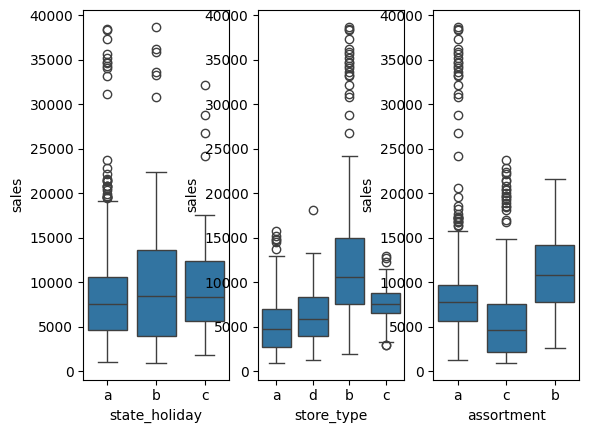

In [25]:
aux1 = df1[ (df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ] 

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. PASSO 2 - FEATURES EMGENERING


In [26]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

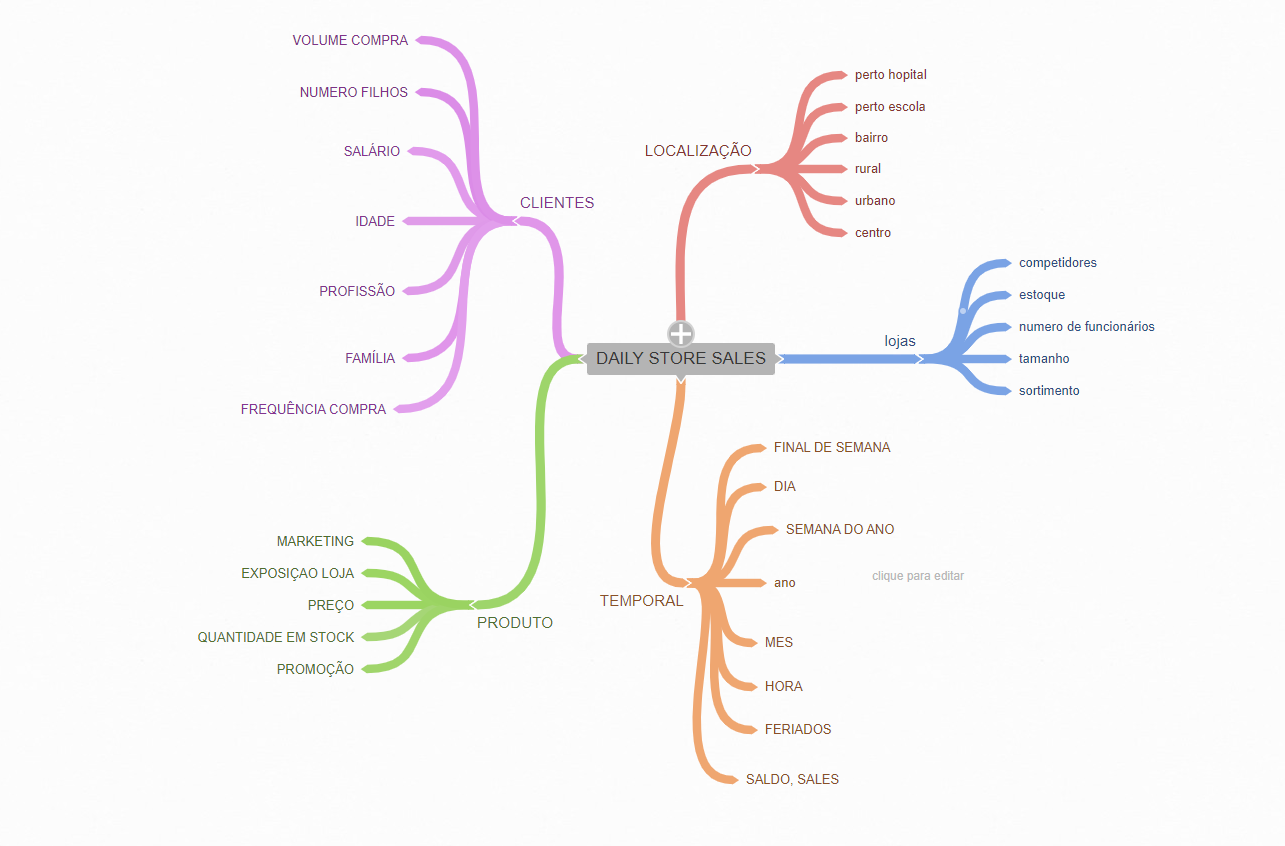

In [27]:
Image('..//img//mapa_hipotese.png')

## 2.1 Criaçao das Hipoteses
essas hipoteses sao criadas em uma reunião com todos os times da empresa. 

### 2.2.1 Hipoteses Lojas

**1.** lojas como maior quadro de funcionarios deveriam vender mais.  

**2.** lojas com maior estoque deveriam vender mais.

**3.** lojas com maior porte deveriam vender mais.

**4.** lojas com menor porte deveriam vender menos.

**5.** lojas com competidores mais proximos deveriam vender menos.

**6.** lojas com maior sortimento deveriam vender mais.

**7.** lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas (maiores descontos), deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas com promoçoes ativas por mais tempo deveriam vender mais.

**8.** Lojas com mais dias de promoçao deveriam vender mais .

### 2.2.3 Hipoteses Tempo

**1.** Lojas que fecham nos feriados deveriam vender menos. 

**2.** Lojas que tem mais feriados deveriam vender menos. 

**3.** Lojas que abrem nos primeiros 6 meses deveriam vender mais. 

**4.** Lojas que abrem nos finais de semanas deveriam vender mais. 

**5.** Lojas deveriam vender mais depois do dia 10 do mes.

**6.** Lojas deveriam vender menos durantes feriados escolares.

## 2.2 Lista final de hipoteses (priorizando as hipoteses)


**1.** lojas com competidores mais proximos deveriam vender menos.

**2.** lojas com maior sortimento deveriam vender mais.

**3.** lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com mais promoções consecutivas deveriam vender mais.

**5.** Lojas com promoçoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoçao deveriam vender mais .

**7.** Lojas que fecham nos feriados deveriam vender menos. 

**8.** Lojas que tem mais feriados deveriam vender menos. 

**9.** Lojas que abrem nos primeiros 6 meses deveriam vender mais. 

**10.** Lojas que abrem nos finais de semanas deveriam vender mais. 

**11.** Lojas deveriam vender mais depois do dia 10 do mes.

**12.** Lojas deveriam vender menos durantes feriados escolares.

**13.** Lojas deveriam vender mais no segundo semestre do ano

## 2.3 Features Engineering 

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear 
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['conpetition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['conpetition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since ( fazando a coluna com a quantidade semanas da promoçao)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-W' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'  )


In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()

## 3.1 Filtragem das linhas 

In [31]:
df3.shape

(1017209, 29)

In [32]:
# as linhas que me intereçao sao so as diferentes de 0 pq 0 quer dizer que a loja esta fecha
df3 = df3[( df3['open'] != 0 ) & (df3['sales'] > 0)]
df3.shape

(844338, 29)

## 3.2. Seleção da colunas 

In [33]:
# retirando a customers pq ela nao e um dado que eu teria no momento de prediçao so teria esses dados quando a loja começace a vender
cols_drop = ['customers', 'open', 'promo_interval', 'mouth_map']
df3 = df3.drop( cols_drop, axis=1 )

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'conpetition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 4 - ANALISE EXPLORATORIA DOS DADOS

In [35]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

/tmp/ipykernel_2360/1017767876.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'] );


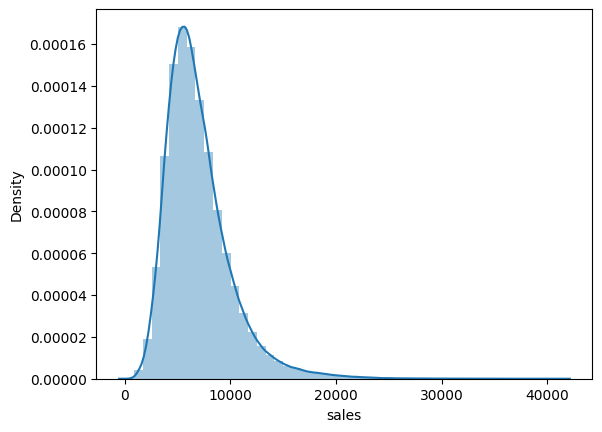

In [36]:
sns.distplot( df4['sales'] );

# normalizaçao dos dados
#sns.distplot( np.log1p( df4['sales'] ) )


### 4.1.2. Numerical Variable

/tmp/ipykernel_2360/388276008.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_atributes.hist(bins=25, ax=ax)


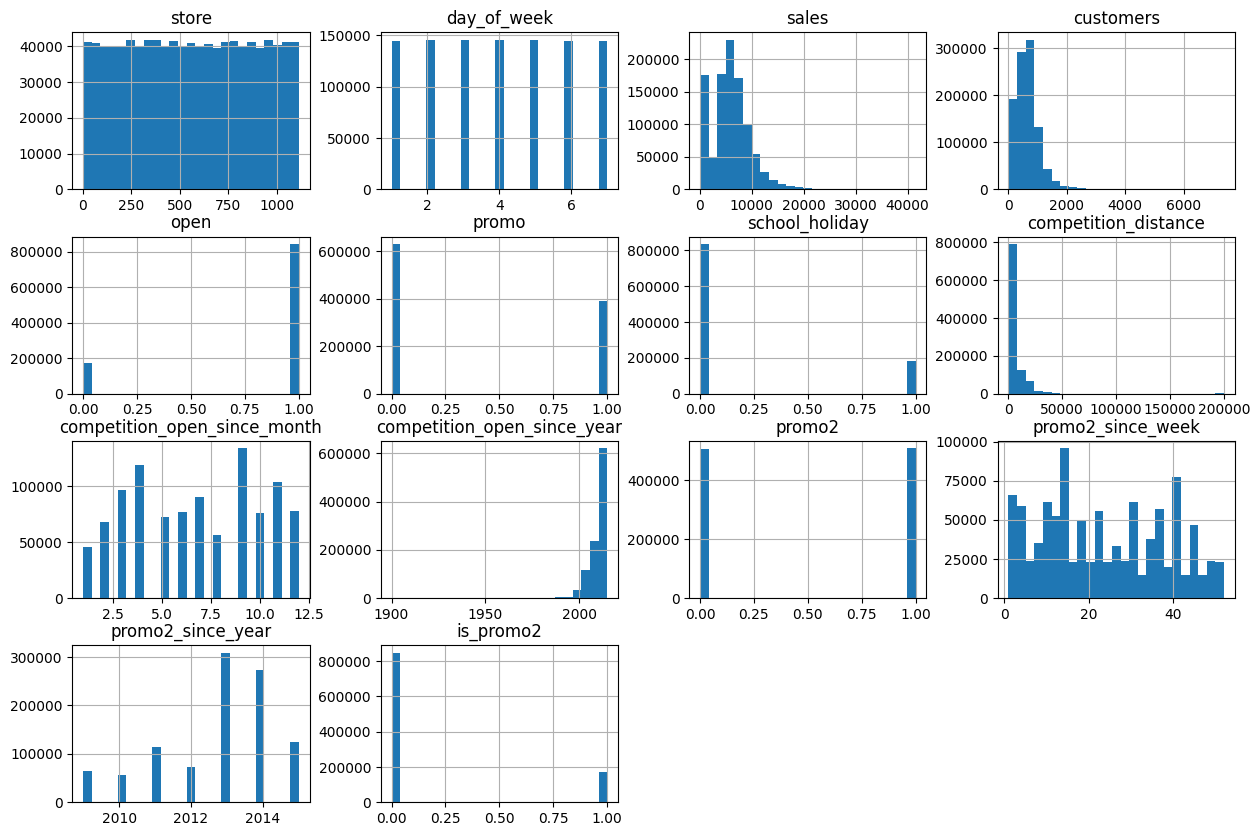

In [37]:
# Crie uma figura e eixos separados
fig, ax = plt.subplots(figsize=(15, 10))

# Gere o histograma nos eixos especificados
num_atributes.hist(bins=25, ax=ax)

# Exiba o gráfico
plt.show()


### 4.1.3 Categorical Variable

In [38]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,mouth_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [39]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/tmp/ipykernel_2360/1663340254.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade=True)
/tmp/ipykernel_2360/1663340254.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday', shade=True)
/tmp/ipykernel_2360/1663340254.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True)
/tmp/ipykernel_2360/1663340254.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fi

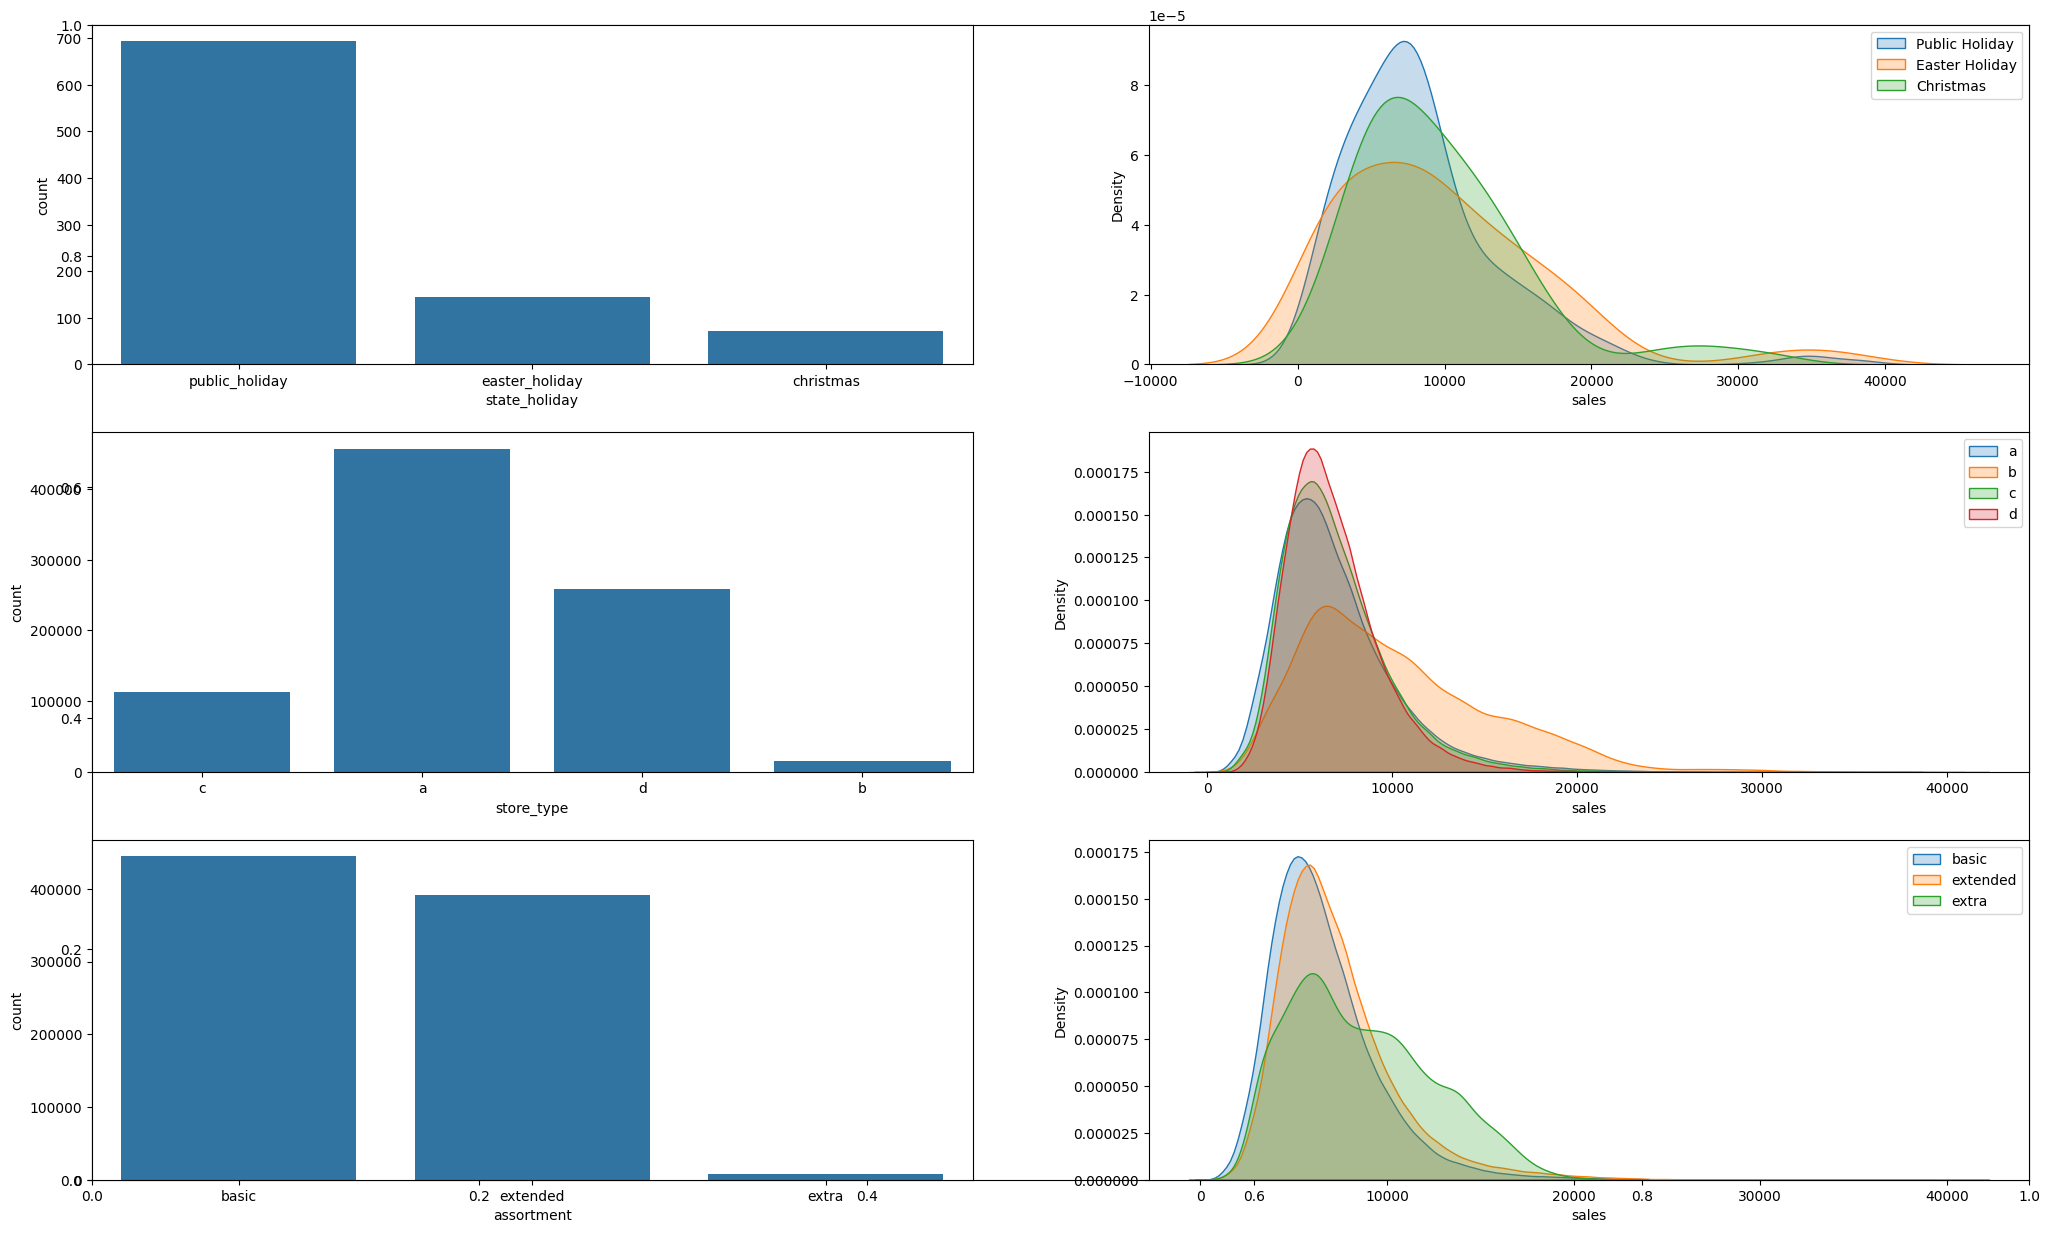

In [40]:
#state_holiday
fig, ax = plt.subplots(figsize=(25, 15))
plt.subplot( 3, 2, 1 )
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( x=a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True)
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()

# Exiba o gráfico
plt.show()

## 4.2. Análise Bivariada

### **H1.** lojas com maior sortimento (classificação) deveriam vender mais.
**FALSA:** Lojas com MAIOR SORTIMENTO vendem MENOS.


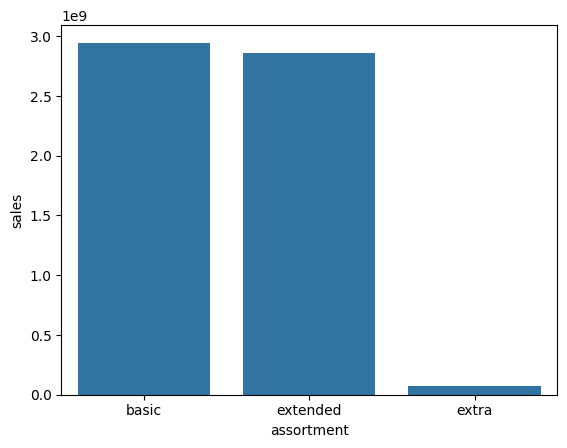

In [41]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

<Axes: xlabel='year_week'>

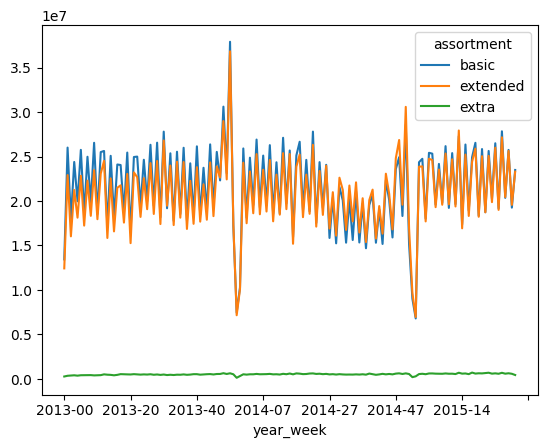

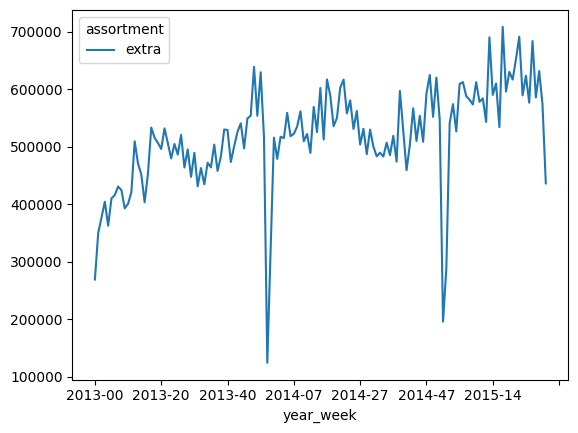

In [42]:
# com essa tabela acima esta dizendo que a hipotese e falsa 
# agora para validar de vez vamos ver se a soma de vendas por sortimento por semana para ver se a extra alguma semana ja foi a que mais vendeu para ver se essa hipotese ja fez sentido um dia
aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# analisando o conportamento do assortment extra

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### **H2.** lojas com competidores mais proximos deveriam vender menos.
**FALSA:** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


/tmp/ipykernel_2360/2028597937.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()


<Axes: >

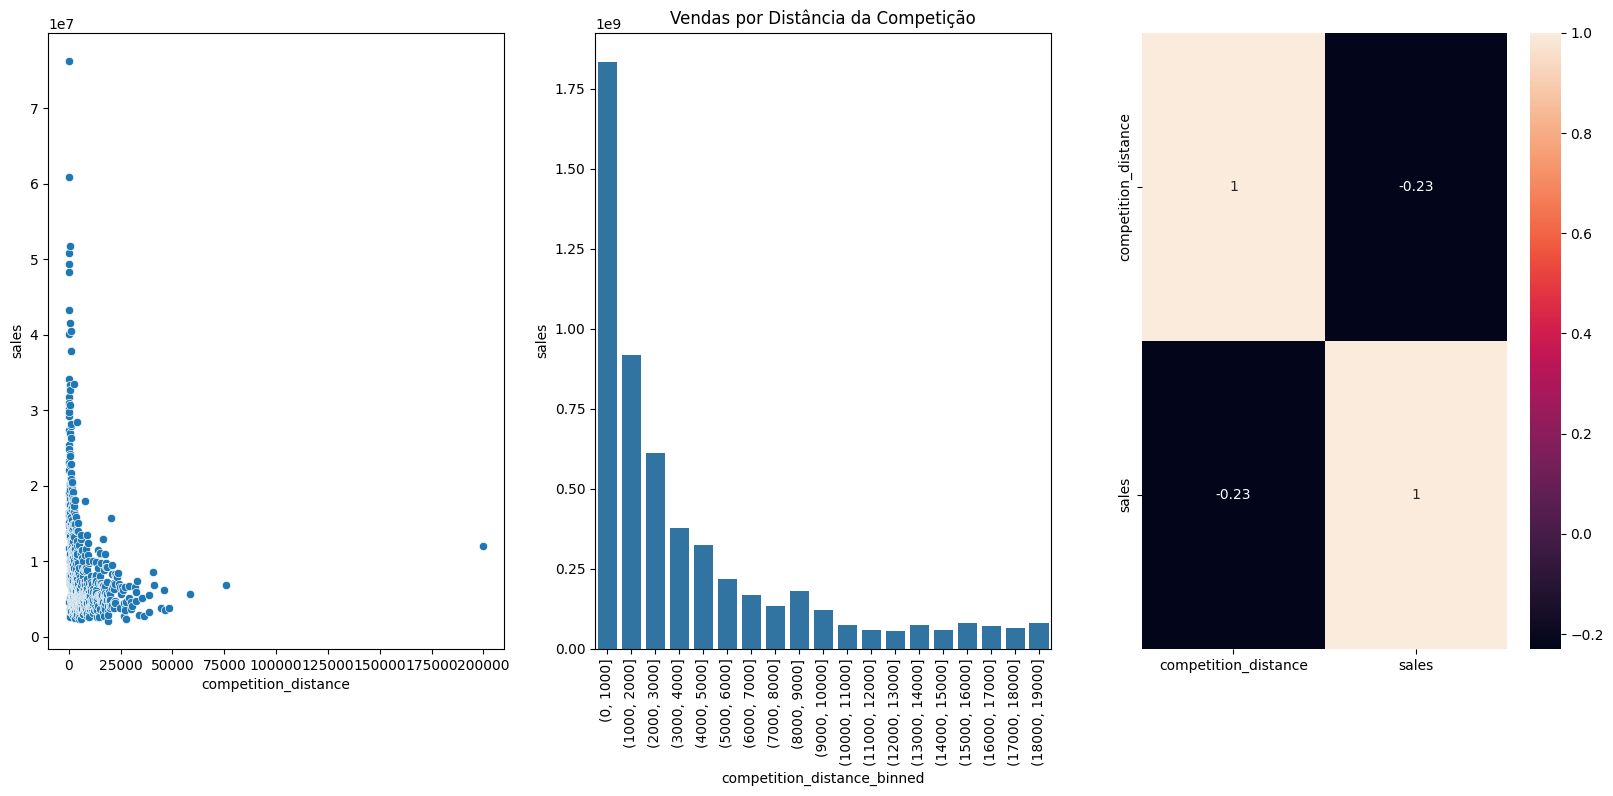

In [43]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
#plt.figure(figsize=(12, 6))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.title('Vendas por Distância da Competição')
plt.xticks(rotation=90)


plt.subplot(1, 3, 3)
numeric_cols = aux1.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(method='pearson'), annot=True)




### **H3.** lojas com competidores a mais tempo deveriam vender mais.
**FALSE:** Lojas com COMPETIDORES A MAIS TEMPO vende MENOS

<Axes: >

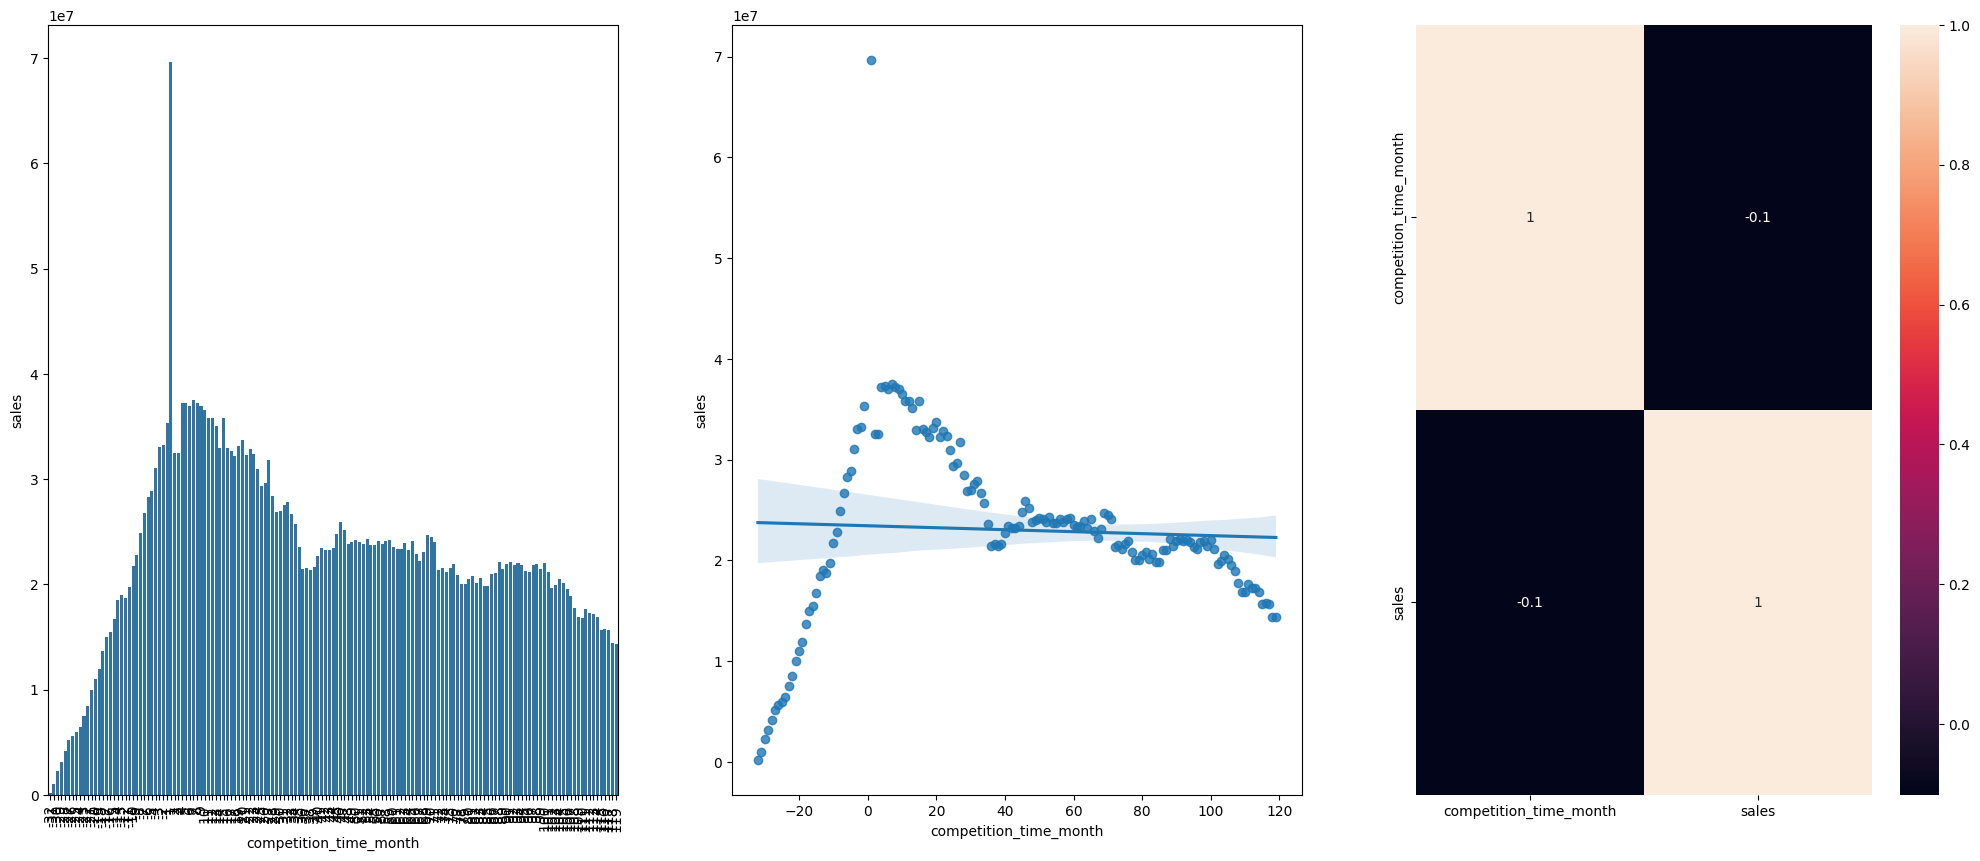

In [44]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
plt.figure(figsize=(25, 10))
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


### **H4.** Lojas com promoçoes ativas por mais tempo deveriam vender mais.
**FALSE:** Lojas com promoçoes ativas por mais tempo vendem menos

a feature 'promo_time_week' provavelmente nao vai ser colocada no algoritmo porque sua correlação e muito proximo de 0 entao e muito ruim a correlação

<Axes: >

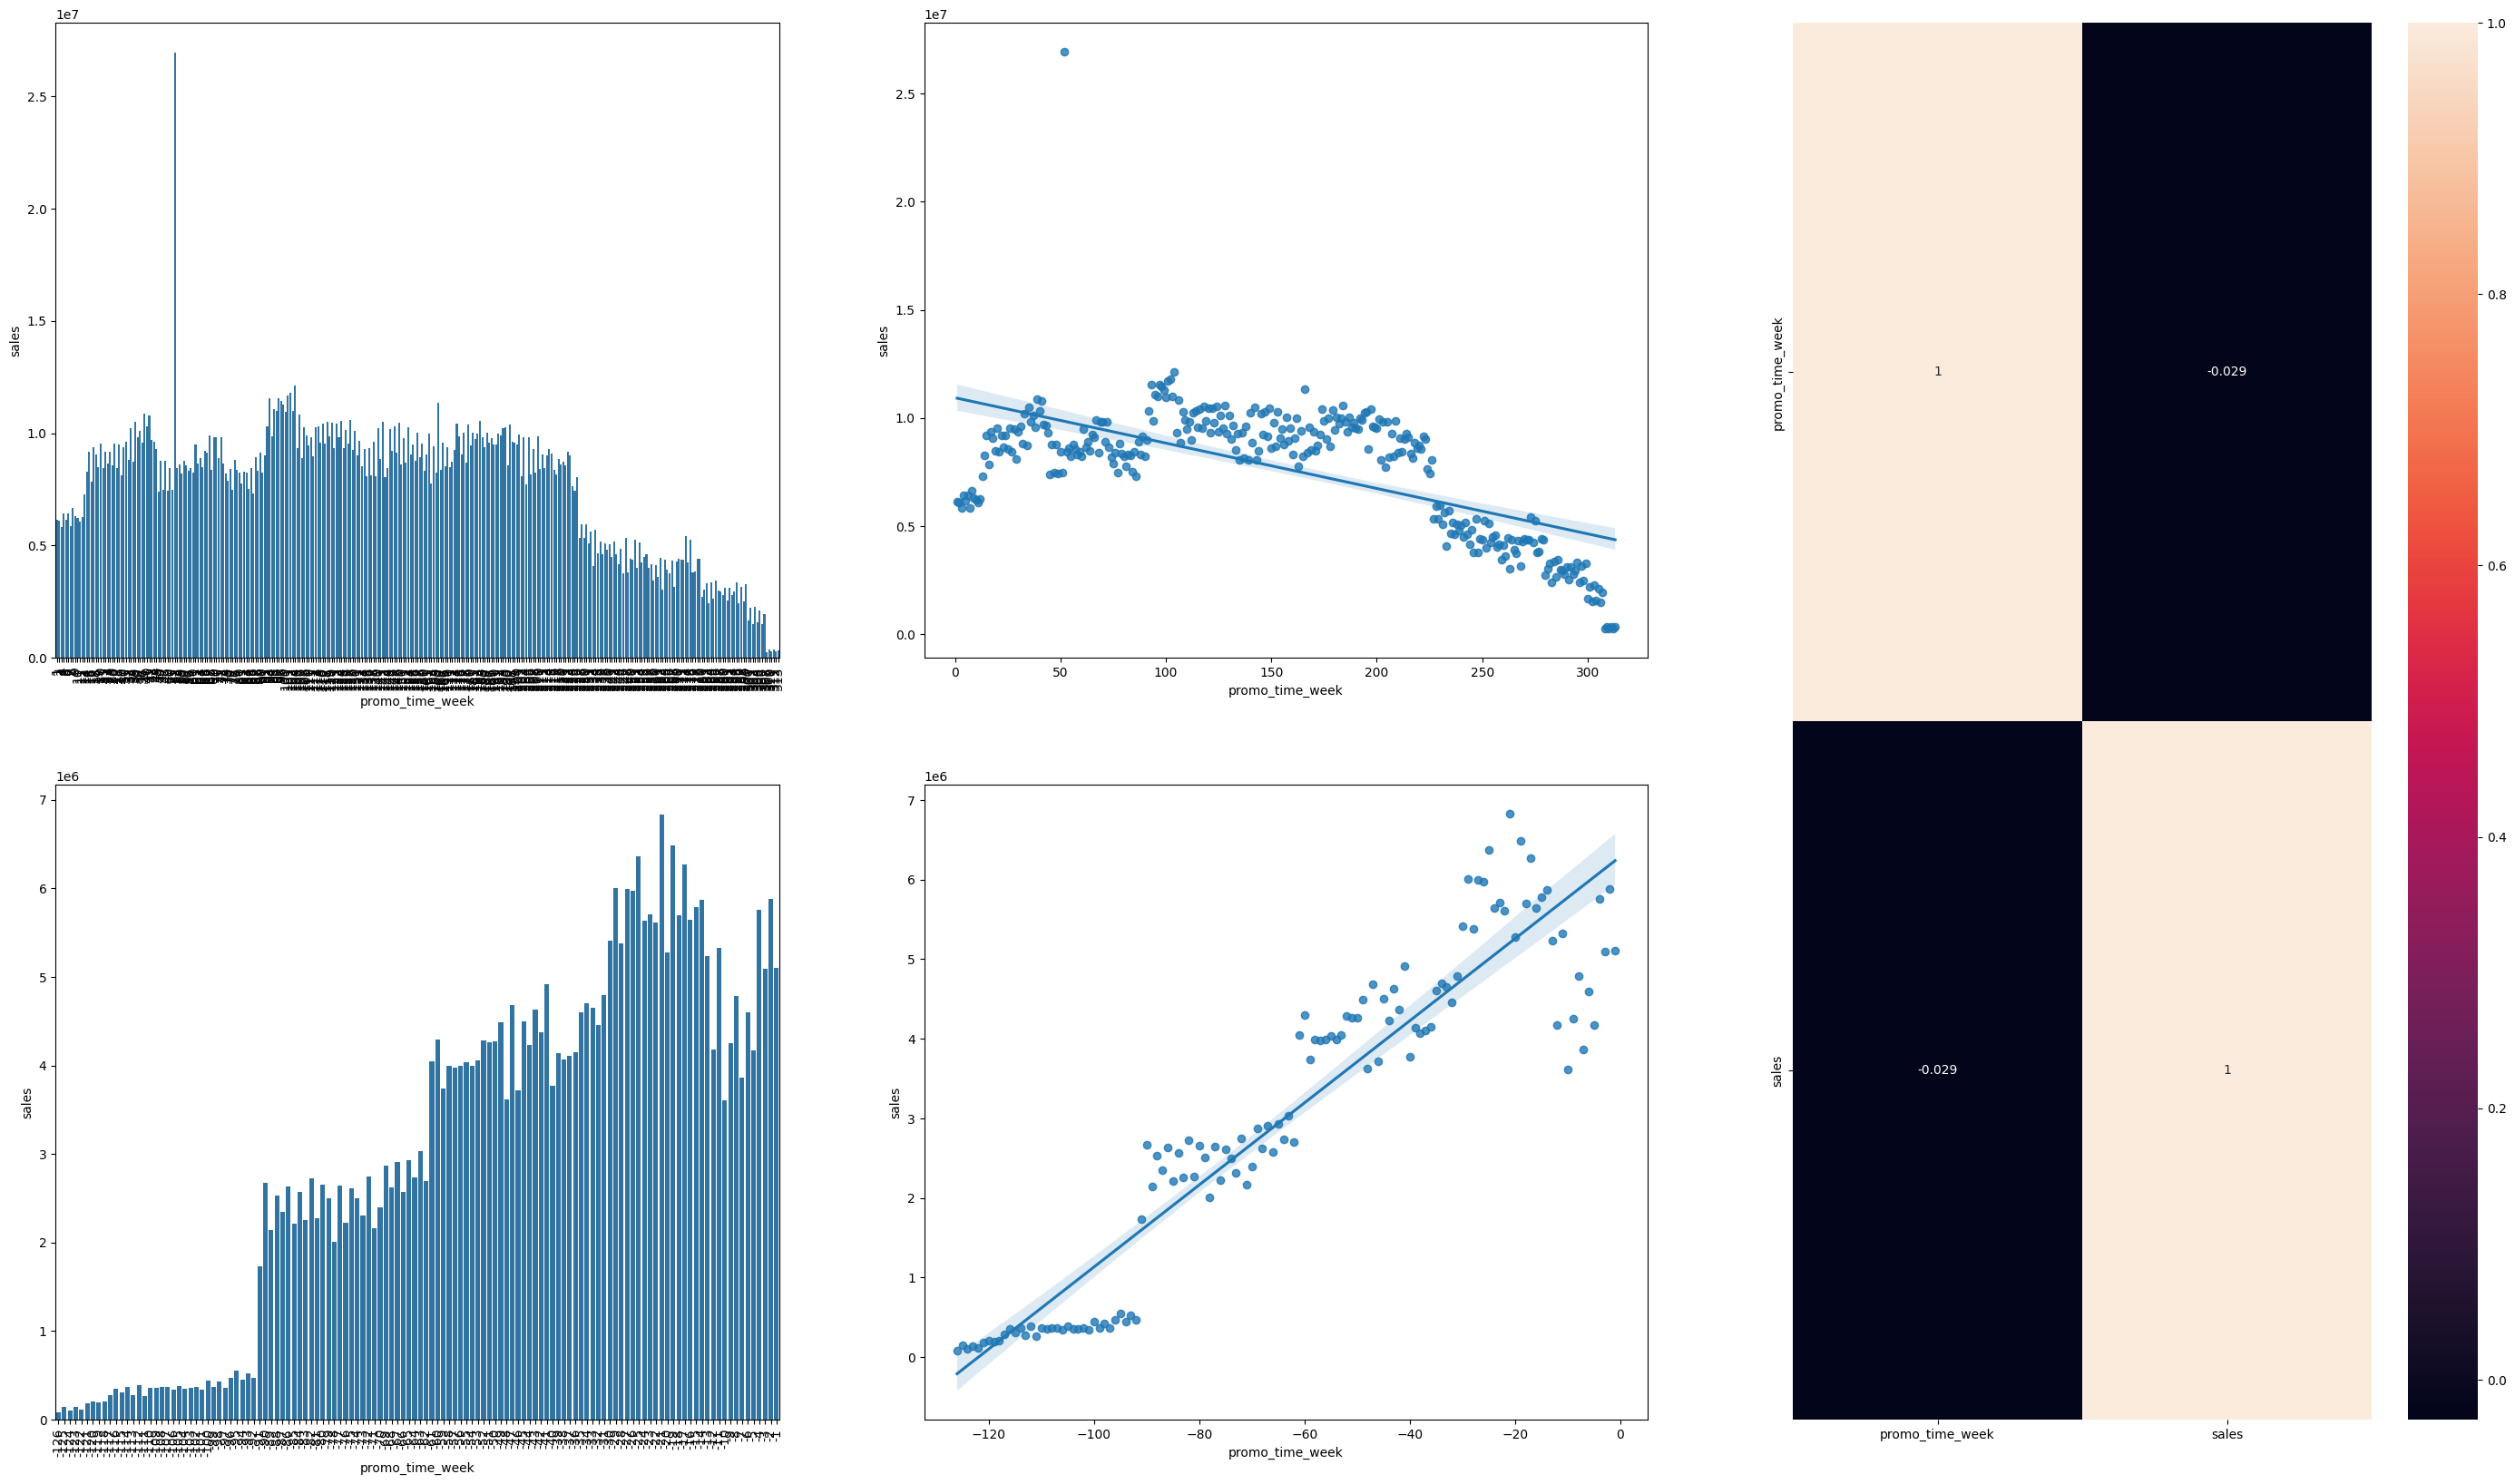

In [45]:
# 'promo_time_week':  coluna com a quantidade semanas da promoçao
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.figure( figsize=[35, 20] )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ]# promo extendida
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ]# promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### <s>**H5.** Lojas com mais dias de promoçao deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE:** Lojas com mais promoções consecutivas vendem menos

In [46]:
df4[['promo', 'promo2', 'sales']].groupby( [ 'promo', 'promo2' ] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


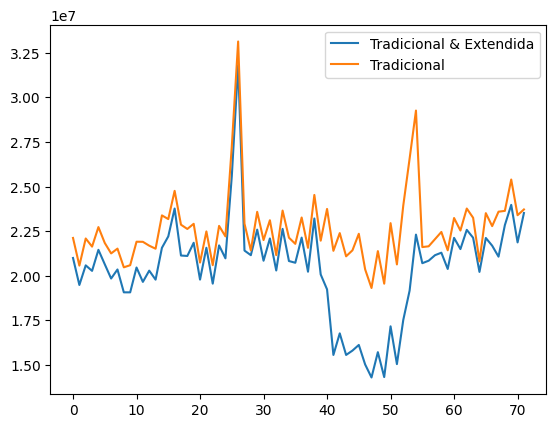

In [47]:
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 1 ) ][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 0 ) ][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']  )

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais. 
**FALSE:** Lojas abertas durante o feriado de natal vendem menos

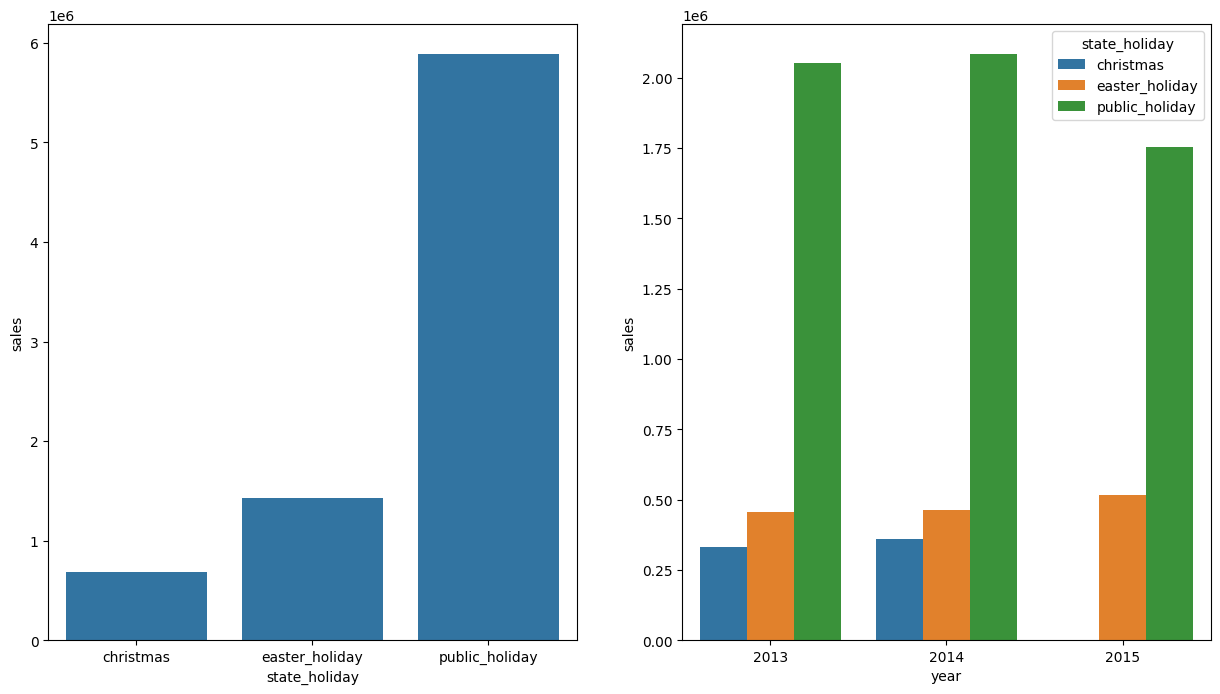

In [48]:
aux = df4[df4['state_holiday'] != 'regular_day' ]
plt.figure( figsize=[15,8] )
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()  
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 =aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao logo dos anos. 
**FALSE:** Lojas estao vendendo menos com o passar dos anos

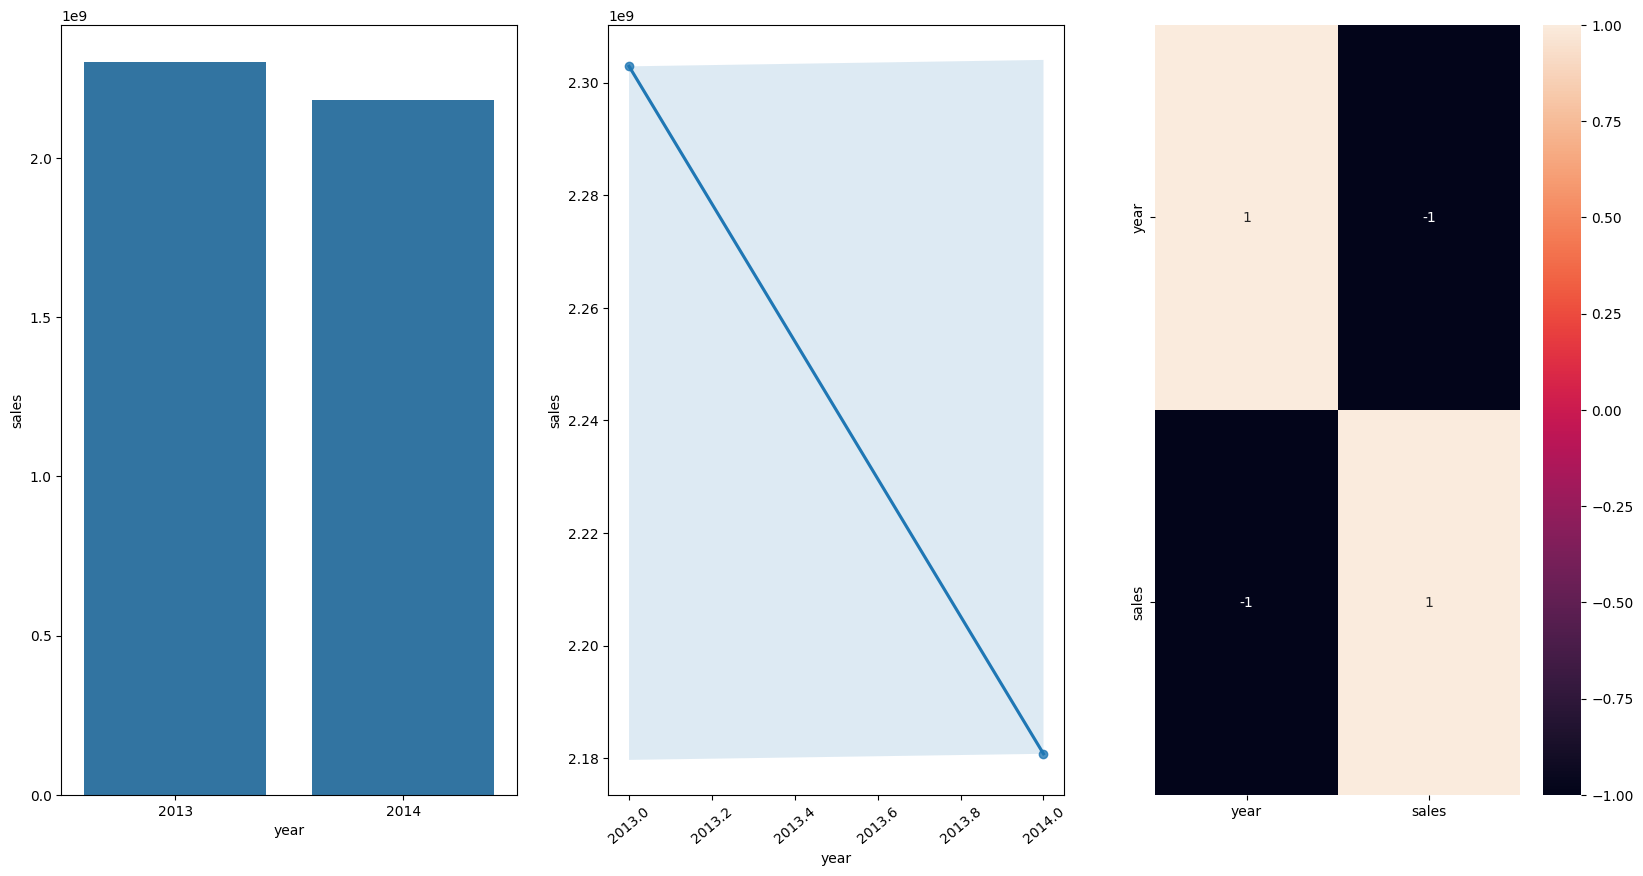

In [49]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
aux1 = aux1[aux1['year'] != 2015] # retirando 2015 esses dados vão so até agosto de 2015 entao ele vai dar menor venda de qualquer jeito pq o ano ainda nao acobou
 
plt.figure( figsize=[20,10] )
plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 )
plt.xticks( rotation=40 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano. 
**FALSE:** lojas vendem menos no segundo semestre do ano 

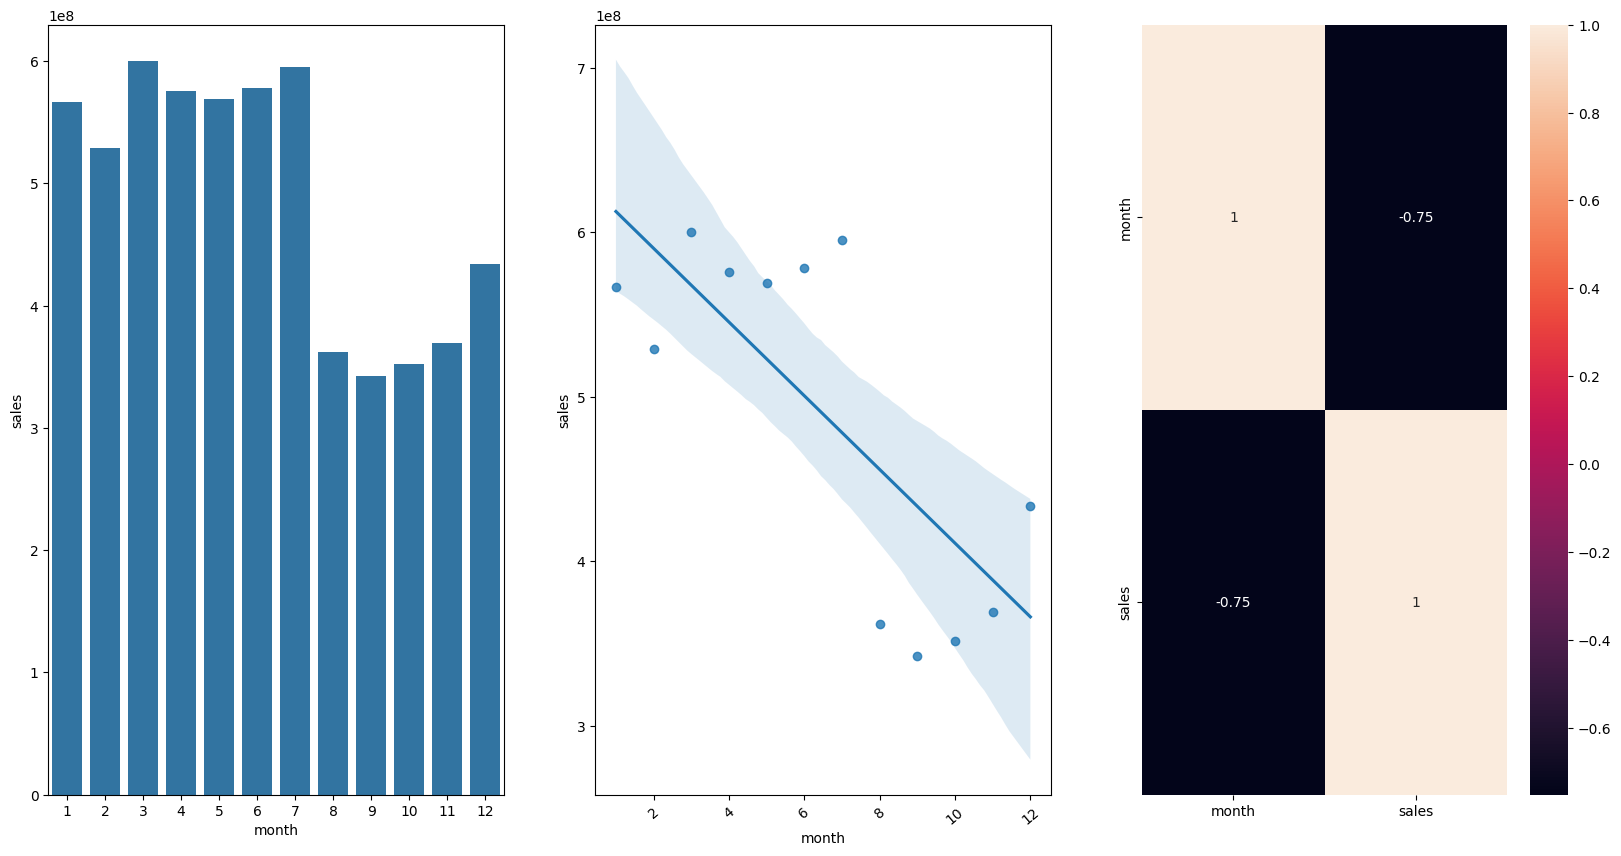

In [50]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.figure( figsize=[20,10] )
plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 )
plt.xticks( rotation=40 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 do mes.
**VERDADEIRO:** Lojas vendem mais depois do dia 10 de cada mes

<Axes: xlabel='before_after', ylabel='sales'>

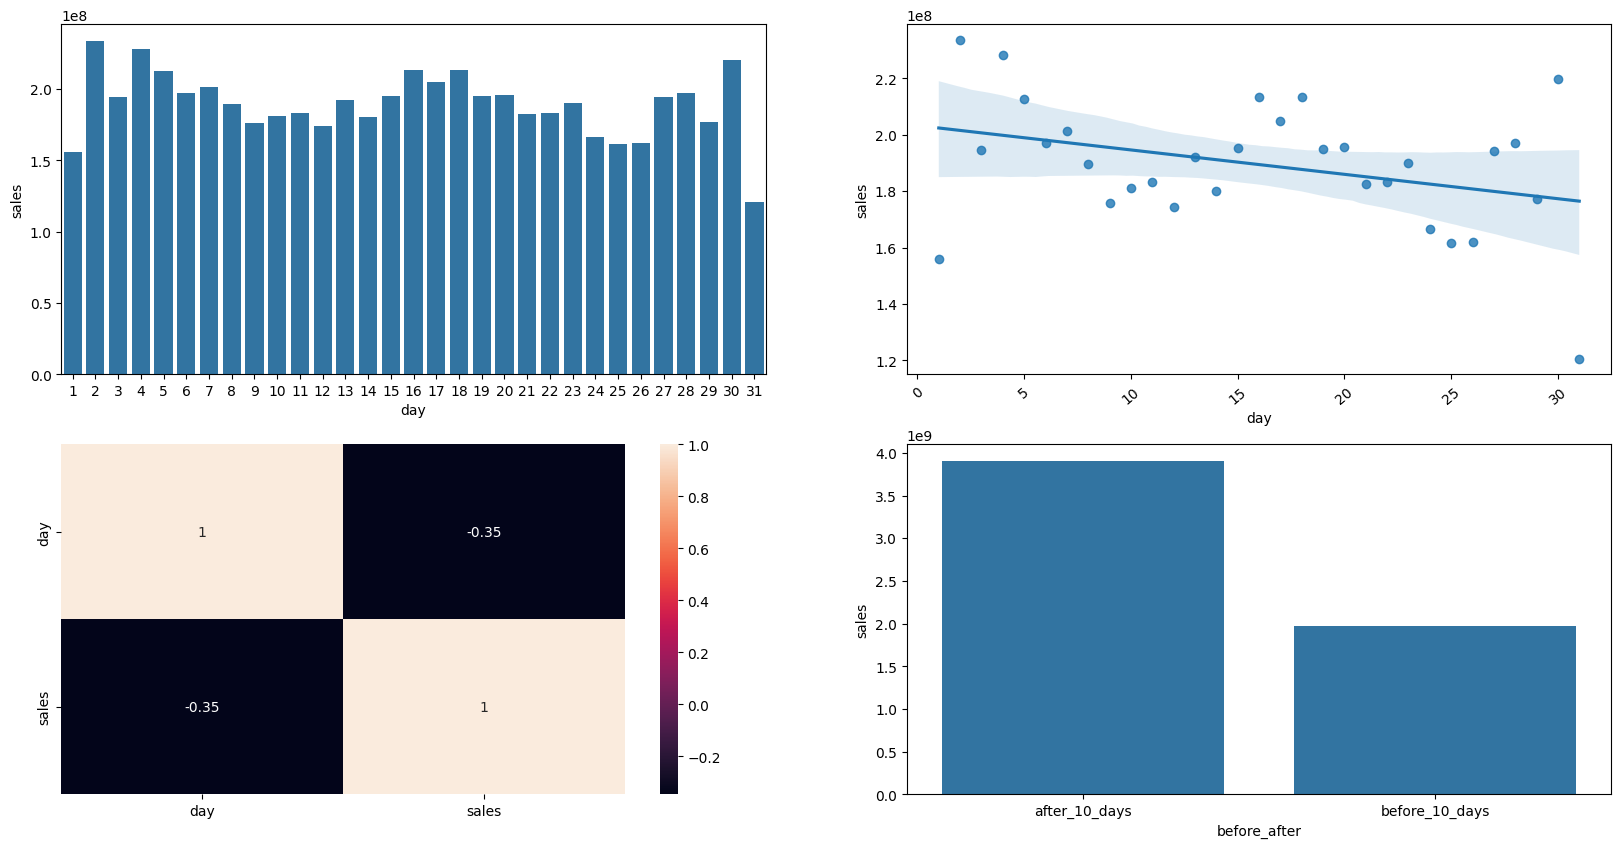

In [51]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
#aux1 = aux1[aux1['year'] != 2015] # retirando 2015 esses dados vão so até agosto de 2015 entao ele vai dar menor venda de qualquer jeito pq o ano ainda nao acobou
 
plt.figure( figsize=[20,10] )
plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 )
plt.xticks( rotation=40 );

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2 )

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA:** lojas vendem menos nos finais de semana.

In [52]:
df4['day_of_week'].unique()

array([5, 4, 3, 2, 1, 7, 6])

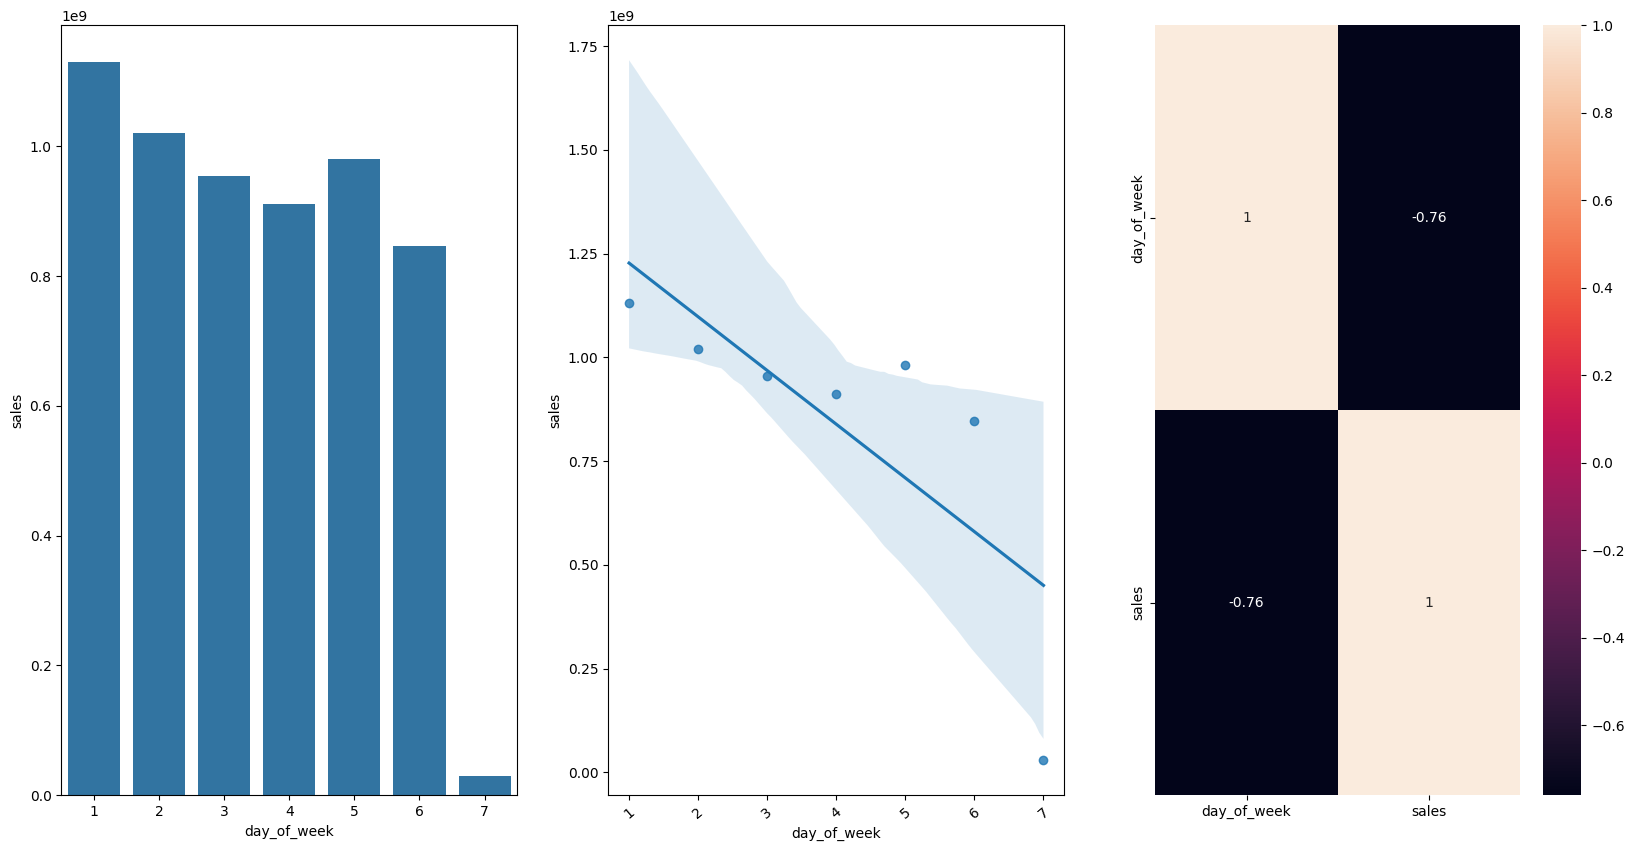

In [53]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
#aux1 = aux1[aux1['year'] != 2015] # retirando 2015 esses dados vão so até agosto de 2015 entao ele vai dar menor venda de qualquer jeito pq o ano ainda nao acobou
 
plt.figure( figsize=[20,10] )
plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 )
plt.xticks( rotation=40 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### **H12.** Lojas deveriam vender menos durantes feriados escolares.
**VERDADEIRO:** Lojas vendem menos durante os feriados escolares.

**OBS:** no mes de julho as vendas no feriados escolares quase se equiparam e em agosto as vendas no feriados escolares vendem mais  

<Axes: xlabel='month', ylabel='sales'>

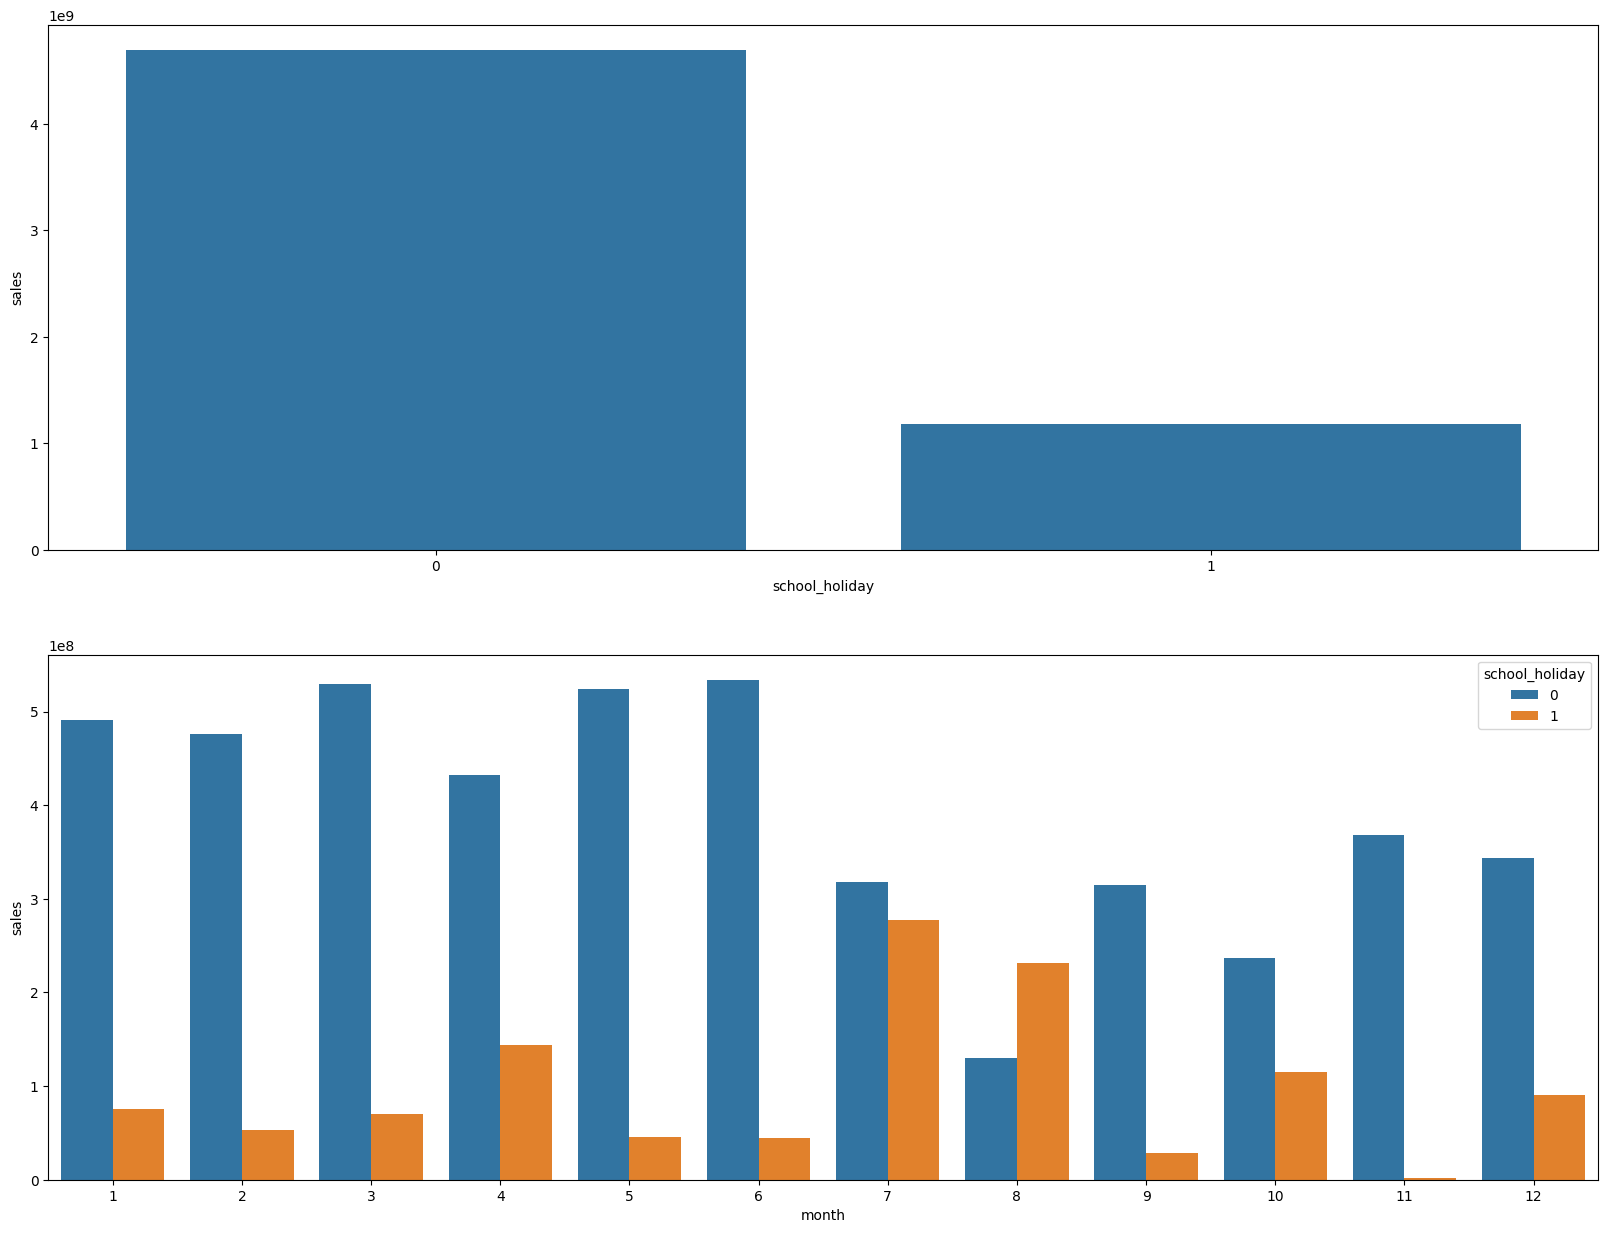

In [54]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
#aux1 = aux1[aux1['year'] != 2015] # retirando 2015 esses dados vão so até agosto de 2015 entao ele vai dar menor venda de qualquer jeito pq o ano ainda nao acobou
 
plt.figure( figsize=[20,15] )
plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 )

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )


### 4.2.1 Resumos das Hipoteses

In [55]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. analise Multivariada:

### 4.3.1 Numerical Attributes

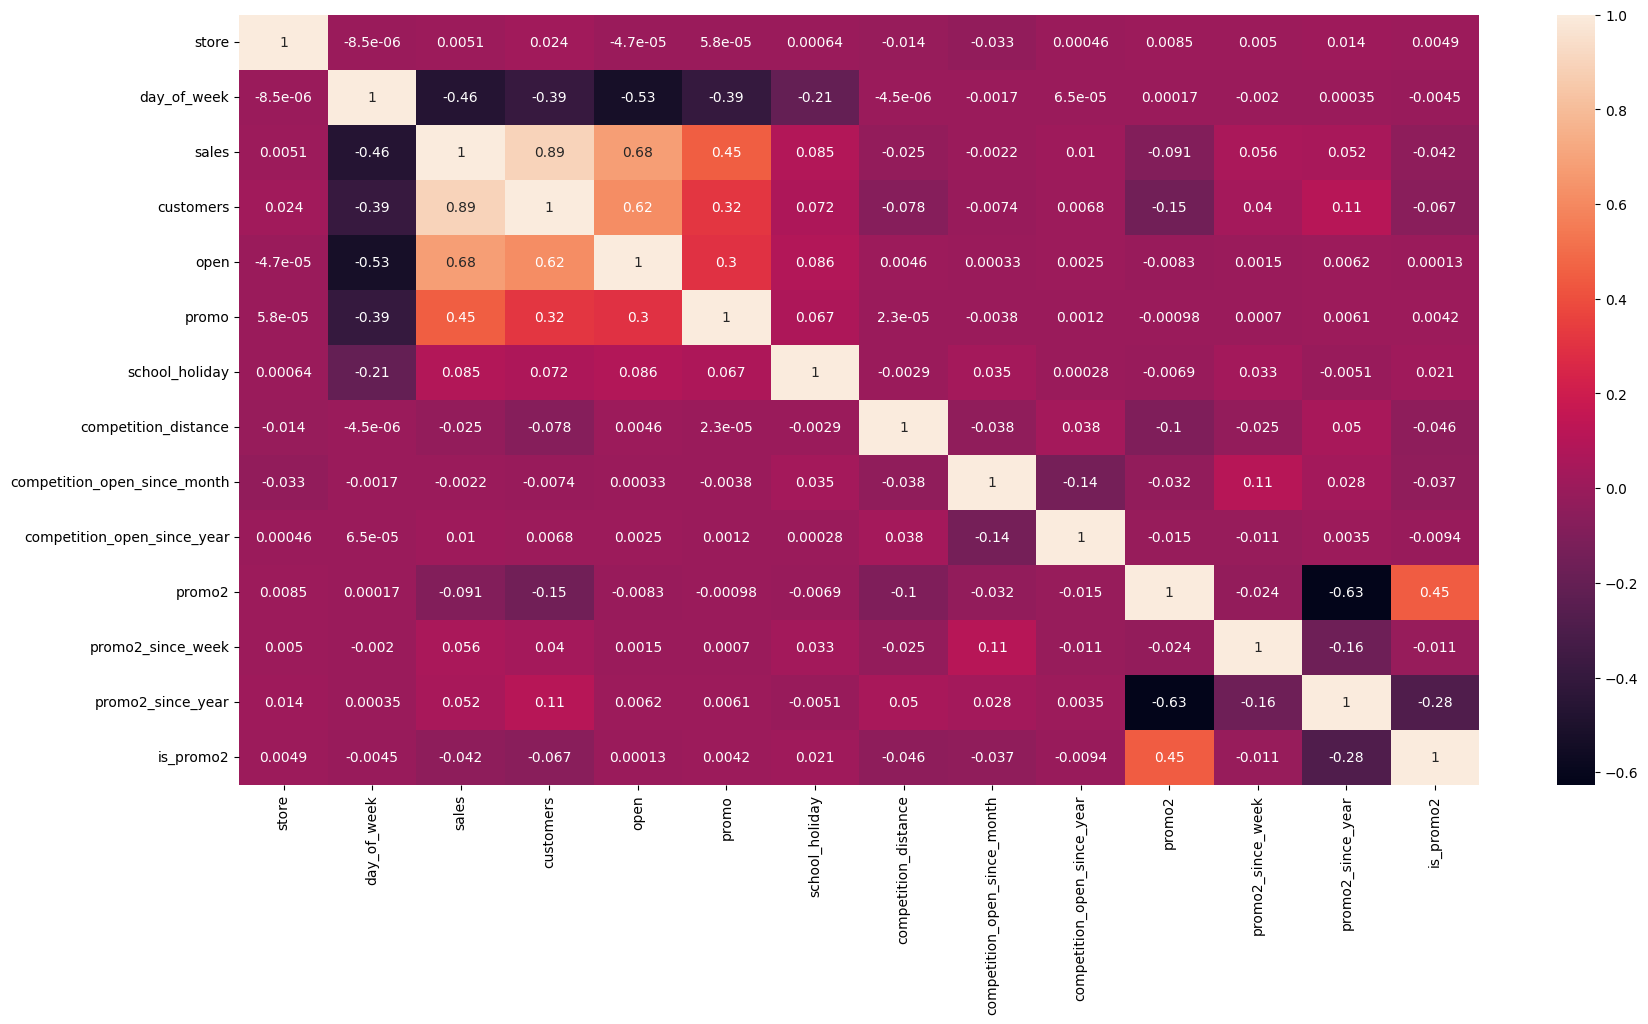

In [56]:
correlation = num_atributes.corr( method='pearson' )
plt.figure(figsize=[20,10])
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

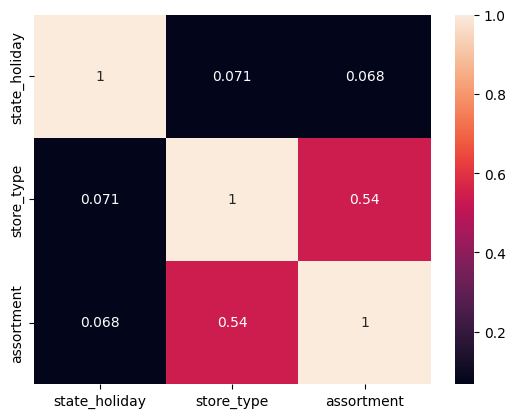

In [57]:
# only categorical data
a = df4.select_dtypes( include='object' )

#calculete crame v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( { 'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],     
                'assortment': [a7, a8, a9]
            } )
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0. PASSO 5 - DATA PREPARATION

In [58]:
df5 = df4.copy()

## 5.1. Normalizacao

 **A Primeira coisa a se fazer e encotrar variaveis com uma distribuiçao normal** na aba 4.1.2. Numerical Variable da para ver a 
 distribuiçao dos dados e **nao tem dados com distribuiçao normal** entao nao vai ser utilizado a tecnica de normalização nesses dados.

## 5.2. Rescaling
Fazer o rescaling dos dados é essencial porque muitos algoritmos de aprendizado de máquina tendem a dar mais peso às variáveis com valores mais altos, independentemente da sua importância real. Isso pode distorcer o modelo e afetar sua performance. Além disso, ter todas as variáveis na mesma escala facilita a convergência mais rápida dos algoritmos, torna a interpretação dos modelos mais fácil e reduz problemas numéricos. Em resumo, o rescaling garante que as variáveis sejam tratadas de forma equilibrada, resultando em modelos mais justos e eficazes.

A técnica de transformação **minmax** é muito boa, porém um pouco menos robusta. Portanto, ao realizar a transformação, é necessário tomar cuidado com os outliers, pois essa transformação utiliza o máximo e o mínimo. Em colunas com outliers, é melhor usar a técnica **Robust Scaler**, que é mais robusta e não tem problemas com outliers. No entanto, é aconselhável usar essa técnica apenas em colunas com outliers, pois ela é um pouco inferior ao **minmax** para colunas sem outliers.

In [59]:
# encotrando a varible numerical
a = df5.select_dtypes( include=['int64', 'float64'] )
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


<Axes: ylabel='promo_time_week'>

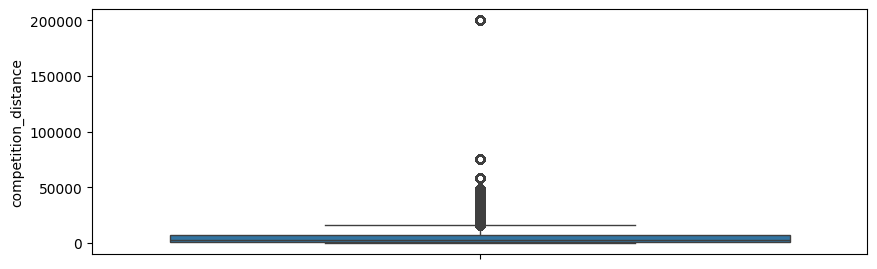

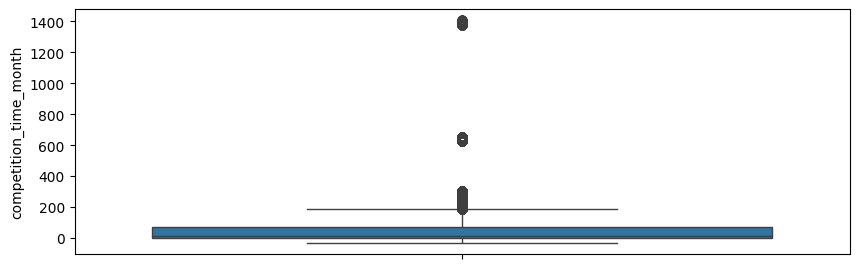

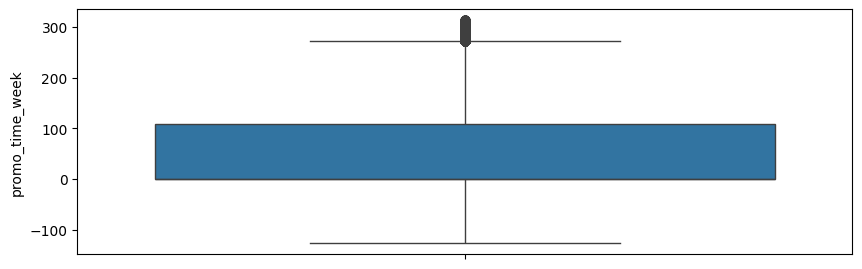

In [60]:
# as coluna que serao Rescaling
# competition_distance
# year
# competition_time_month
# promo_time_week

# verificando qual sistemas vai ser usada em cada coluna usar o minmax ou Robust Scaler ( ou seja verificado os outliers na coluna ).
plt.figure( figsize=[10,7] )
plt.subplot(2, 1, 1)
sns.boxplot( df5['competition_distance'] )

plt.figure( figsize=[10,7] )
plt.subplot(2, 1, 2)
sns.boxplot( df5['competition_time_month'] )

plt.figure( figsize=[10,7] )
plt.subplot(2, 1, 2)
sns.boxplot( df5['promo_time_week'] )

# a coluna year não precisa verificar outliears porque e o year  

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

# no competition_distance vai ser usada o Robust Scaler.
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/home/gustavo/Projects/CDS/DS_em_producao/parameter/competition_distance_scale.pkl', 'wb' ) )

# no competition_time_month vai ser usada o Robust Scaler.
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/home/gustavo/Projects/CDS/DS_em_producao/parameter/competition_time_month_scale.pkl', 'wb' ) )

# no promo_time_week vai ser usada o MinMaxScaler por que seus outliers nao são tão relevantes.
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( '/home/gustavo/Projects/CDS/DS_em_producao/parameter/promo_time_week__scale.pkl', 'wb' ) )

# no year vai ser usada o MinMaxScaler por que nao tem outliers .
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/home/gustavo/Projects/CDS/DS_em_producao/parameter/year_scale.pkl', 'wb' ) )


/tmp/ipykernel_2360/4082855515.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['competition_distance'] );


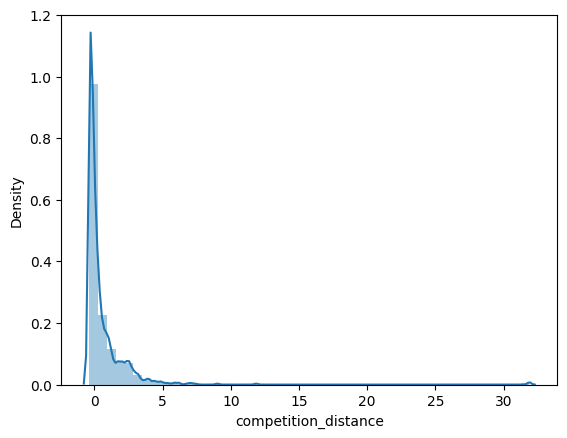

In [62]:
sns.distplot( df5['competition_distance'] );

## 5.3. Transformacao 

### 5.3.1. Encoding

In [63]:
#ver o dataframe completo
#pd.set_option('display.max_columns', len(df5.columns))
#df5.head()

In [64]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, columns=['state_holiday'], dtype='uint8')

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/home/gustavo/Projects/CDS/DS_em_producao/parameter/store_type_scale.pkl', 'wb' ) )

# assortment - Ordinal Encoding
#print(df5['assortment'].unique())

assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict ) 

### 5.3.2. Response variable Transformation

/tmp/ipykernel_2360/773345782.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['sales'] );


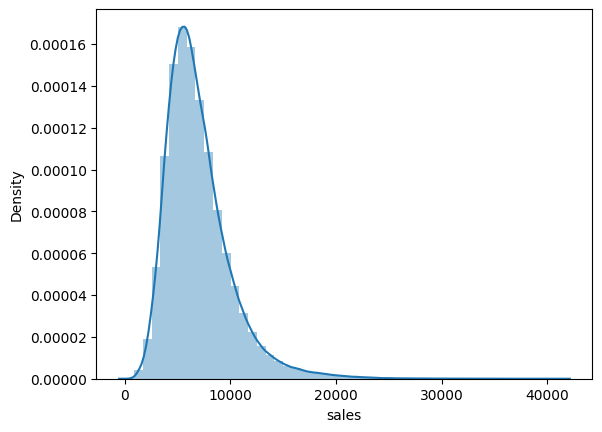

In [65]:
sns.distplot( df5['sales'] );

/tmp/ipykernel_2360/1179269980.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['sales'] )


<Axes: xlabel='sales', ylabel='Density'>

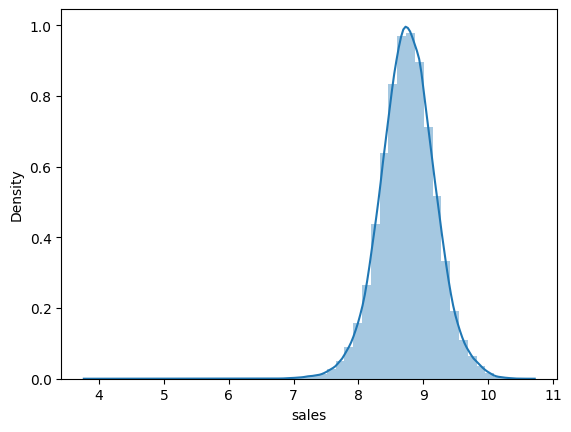

In [66]:
df5['sales'] = np.log1p( df5['sales'] ) 
sns.distplot( df5['sales'] )

### 5.3.3 Nature Transformation 

EX: voce tem uma coluna de mês e essa coluna vai de 1 a 12 entao o mes 12 e mes 1 do proximo ano para o algoritmo fical muito loge ai entra a transformação de natureza que vai fazer com que esses , meses tem um formtao ciclico que vai fazer com que o mes 12 desse ano fique proximo do meses 1 do proximo ano

In [67]:
# Criando o sistema cicl 
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) 

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) 

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) 
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) 
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) 

# 6.0. PASSO 6 - FEATURE SELECTION

In [68]:
df6 = df5.copy()

## 6.1. Split DataFrame into Training and test dataset

In [69]:
pd.set_option('display.max_columns', len(df6.columns))


In [70]:
# {Dropando algumas das  variveis originais que eu criei variaveis derevidas delas duramte os PASSOS 2 E PASSO 5}
# {Da varivel promo_since eu derivei a variavel promo_time_week} 
# {Mesmo a week_of_year ja sendo uma variavel derivado ela sera dropada porque ela tambem derivel outras variavel entao ela ja nao e mais nesseçari por ela tem as mesmo informaçoes so que agora
# de forma ciclica das 52 semanas do ano que sao as colunas week_of_year_sin | week_of_year_cos .}
# {a variavel conpetition_since derivol a vriavel conpetition_time_month}

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'conpetition_since', 'year_week'  ]
df6 = df6.drop( cols_drop, axis=1 )


In [71]:
# separando traino e teste e mais nao de forma aleatoria porque o problema de negocio e prever as proximas 6 semanas 
# então a separação dos dados vai ser em relação a data o teste sera os dados mais no futuro e o trais os mais no passodo 
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [72]:
# Training Dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Test Dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print( 'Training min Date: {}'.format(X_train['date'].min() ) )
print( 'Training max Date: {}'.format(X_train['date'].max() ) )

print( '\nTest min Date: {}'.format(X_test['date'].min() ) )
print( 'Test max Date: {}'.format(X_test['date'].max() ) )

Training min Date: 2013-01-01 00:00:00
Training max Date: 2015-06-18 00:00:00

Test min Date: 2015-06-19 00:00:00
Test max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [73]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709


In [74]:
# Training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define o regressor RandomForest
rf = RandomForestRegressor( n_jobs=-1 ) 

# Inicializa o Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

# Ajusta o Boruta aos dados de treinamento
#boruta



### 6.2.1 Best Features from Boruta

In [75]:
#cols_selected = boruta.support_.tolist()

# best feature
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[ :, cols_selected ].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

**Merge entre analise exploratoria e Boruta**

Agora como cientista de dados eu tenho que fazer a fusao entre os resoltados do boruta com o resutado das hipoteses do Boruta

**Como estou estou usando o metodo crispe esse merge sera feito no proximo ciclo do crispe** 


In [76]:
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


In [77]:
cols_not_selected_boruta = [
    'is_promo2',
    'month_sin',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_of_year_sin',
    'year']

In [78]:
# slvando o boruta recolocar as colunas "sin" porque o boruta escolheu algumas "cos" sem escolher alguns "sin" 
  
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add  
# a sales e a coluna target e date e uma coluna que sera necessaria.
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [79]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [80]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Avarage Model 

In [81]:
aux1 = x_test.copy()
aux1[ 'sales' ] = y_test.copy()

# Prediction
aux2 = aux1[[ 'store', 'sales' ]].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales' : 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1[ 'predictions' ]

# Performance
# np.expm1 e para reverter a transfomação que foi feita na coluna 'sales' no passo 5.3.2. para que as vendas voltem para o formato original.
# a Transformaçao df5['sales'] = np.log1p( df5['sales'] ) 
baseline_result = ml_error( 'Avarage Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model 

In [82]:
# model  
lr = LinearRegression()
lr.fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
# np.expm1 e para reverter a transfomação que foi feita na coluna 'sales' no passo 5.3.2. para que as vendas voltem para o formato original.
# a Transformaçao df5['sales'] = np.log1p( df5['sales'] ) 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation  

In [83]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr )
#lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [84]:
# model   
lrrl = Lasso( alpha=0.01 )
lrrl.fit( x_train, y_train )

# prediction
yhat_lrrl = lrrl.predict( x_test )

# performance
# np.expm1 e para reverter a transfomação que foi feita na coluna 'sales' no passo 5.3.2. para que as vendas voltem para o formato original.
# a Transformaçao df5['sales'] = np.log1p( df5['sales'] ) 
lrrl_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrrl ) )
lrrl_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1.  Lasso - Cross Validation  

In [85]:
#lrrl_result_cv = cross_validation(x_training, 5, 'Lasso', lrrl )
#lrrl_result_cv

## 7.4. Random Forest Regressor

In [86]:
# model  
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )
#rf.fit( x_train, y_train )

# prediction
#yhat_rf = rf.predict( x_test )

# performance
# np.expm1 e para reverter a transfomação que foi feita na coluna 'sales' no passo 5.3.2. para que as vendas voltem para o formato original.
# a Transformaçao df5['sales'] = np.log1p( df5['sales'] ) 

#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [87]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf )
#rf_result_cv

## 7.5. XGBoost Regressor 

In [88]:
# model  
# eu consigo melhorar bastante esse algorimo almetando o numero de n_estimators
model_xgb  =  xgb.XGBRegressor( objective='reg:squarederror', 
                                n_estimators=100,
                                eta=0.1,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytee=0.9 )

model_xgb.fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
# np.expm1 e para reverter a transfomação que foi feita na coluna 'sales' no passo 5.3.2. para que as vendas voltem para o formato original.
# a Transformaçao df5['sales'] = np.log1p( df5['sales'] ) 
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

/home/gustavo/.pyenv/versions/3.9.18/envs/DS_/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:00:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,805.016208,0.117862,1179.548084


### 7.5.1. XGBoost Regressor - Cross Validation  

In [89]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb )
#xgb_result_cv

## 7.6. Compare Model`s Performance

### 7.6.1 Single Performance

In [90]:
#modelling_result = pd.concat( [ baseline_result, lr_result, lrrl_result, rf_result, xgb_result ] )
#modelling_result = modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation 

In [91]:
#modelling_result_cv = pd.concat( [ lr_result_cv, lrrl_result_cv, rf_result_cv, xgb_result_cv ] )
#modelling_result_cv = modelling_result_cv.sort_values( 'RMSE MEAN' )
#modelling_result_cv
# mesmo o random forest Regressor dando um melhor resultado vai ser utilizado o XGBoost por que com ele da para implemetar o finale tune na mão e 
# pela performance do algorimo que o XGBoost ser muito mais rapido. 

In [92]:
# Salvando o DataFrame em um arquivo CSV
#modelling_result_cv.to_csv('modelling_result_cv.csv', index=False)

In [93]:
modelling_result_cv = pd.read_csv('..//datasets//modelling_result_cv.csv')
modelling_result_cv

,Model Name,MAE MEAN,MAPE MEAN,RMSE MEAN
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
1,XGBoost Regressor,993.4 +/- 176.31,0.14 +/- 0.02,1431.48 +/- 244.42
2,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
3,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. PASSO 8 - HYPERPARAMETER FINE TUNING  

### O MAE é recomendado para relatar resultados ao time de negócios, enquanto o RMSE pode ser mais útil durante o processo de melhorias do algoritmo, especialmente para identificar e lidar com outliers. 

só e recomendo relatar o RMSE e o RMSPE caso a acuracia sejo por exeplo o resultado medico que o menor valor importa

## 8.1. Random Search

In [94]:
import random 
import warnings
warnings.filterwarnings( 'ignore' )

In [95]:
param  =  { 'n_estimators' : [1500, 1700, 2500, 3000, 3500],
            'eta' : [0.01, 0.03], 
            'max_depth' : [3, 5, 9],
            'subsample' : [0.1, 0.5, 0.7],
            'colsample_bytree' : [0.3, 0.7, 0.9],
            'min_child_weight' : [3, 8, 15] }

MAX_EVAL = 10

In [96]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    # chose values for parameters randomly
#    hp = { k : random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )

    # model  
#    model_xgb  =  xgb.XGBRegressor( objective='reg:squarederror', 
#                                    n_estimators=hp['n_estimators'],
#                                    eta=hp['eta'],
#                                    max_depth=hp['max_depth'],
#                                    subsample=hp['subsample'],
#                                    colsample_bytree=hp['colsample_bytree'],
#                                    min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat( [ final_result, result ] )

#final_result

## 8.2. Final Model 

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

In [97]:
param_tuned = { 'n_estimators' : 3000,
                'eta' : 0.03, 
                'max_depth' : 9,
                'subsample' : 0.7,
                'colsample_bytree' : 0.7,
                'min_child_weight' :  3}


In [98]:
# model  
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] )
model_xgb_tuned.fit( x_train, y_train )

# predict
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,630.649066,0.090655,927.738413


In [99]:
MAE = xgb_result_tuned['MAE']
MAPE = xgb_result_tuned['MAPE']
RMSE = xgb_result_tuned['RMSE']

Mean_test = np.expm1( y_test ).mean()

In [100]:
# a divisao do MAE[0] e Mean_test e o resultado do MAPE
print( 'o Resultado do MAE e R${:.2f} e o erro medio e o media e R${:.2f}'.format( MAE[0], Mean_test ) )
print( '_'*65 )
print( 'O Resultado do MAPE e {:.2f}% e o erro medio do algoritmo'.format( MAPE[0] * 100 ) )
print( '_'*65 ) 
print( 'portcentagem de acerto do algoritmo segundo o MAPE foi {:.2f}% '.format( 100 - (MAPE[0] * 100 ) ) )
print( '_'*65 ) 
print( 'o Resultado do RMSE e R${:.2f} e o erro medio e o media e R${:.2f}'.format( RMSE[0], Mean_test ) )
print( '_'*65 ) 
print( 'portcentagem de erro do algoritmo segundo o RMSE foi {:.2f}% '.format( (RMSE[0] /Mean_test )*100 ) )

o Resultado do MAE e R$630.65 e o erro medio e o media e R$6995.16
_________________________________________________________________
O Resultado do MAPE e 9.07% e o erro medio do algoritmo
_________________________________________________________________
portcentagem de acerto do algoritmo segundo o MAPE foi 90.93% 
_________________________________________________________________
o Resultado do RMSE e R$927.74 e o erro medio e o media e R$6995.16
_________________________________________________________________
portcentagem de erro do algoritmo segundo o RMSE foi 13.26% 


In [101]:
MPE = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
print('MPE: {:.2f}%'.format( MPE*100 ))


MPE: 1.03%


# 9.0. PASSO 9 - TRADUÇÃO E INTERPRETAÇÃO DE ERRO  

In [102]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale 
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance 

In [103]:
# sum of predictions das proximas 6 semanas
df91 = df9[ ['store', 'predictions'] ].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply( lambda x : mt.mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply( lambda x : mt.mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios (o pior cenario e o melhor cenario da predição)
df92['worst_scenario'] = df92['predictions'] - df92['MAE'] 
df92['best_scenario'] = df92['predictions'] + df92['MAE'] 

# order columns 
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [104]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
510,511,197478.46875,196917.028980,198039.908520,561.439770,0.095452
671,672,299292.96875,298745.809953,299840.127547,547.158797,0.065538
931,932,272677.43750,272048.883024,273305.991976,628.554476,0.079799
184,185,241381.34375,240786.692581,241975.994919,594.651169,0.089418


### 9.1.1 lojas com a predição muito ruim, quem talvez mereçao o algoritmo especifico no proximo ciclo do CRISPE.   

A maioria das lojas tem o erro do predict de 10%


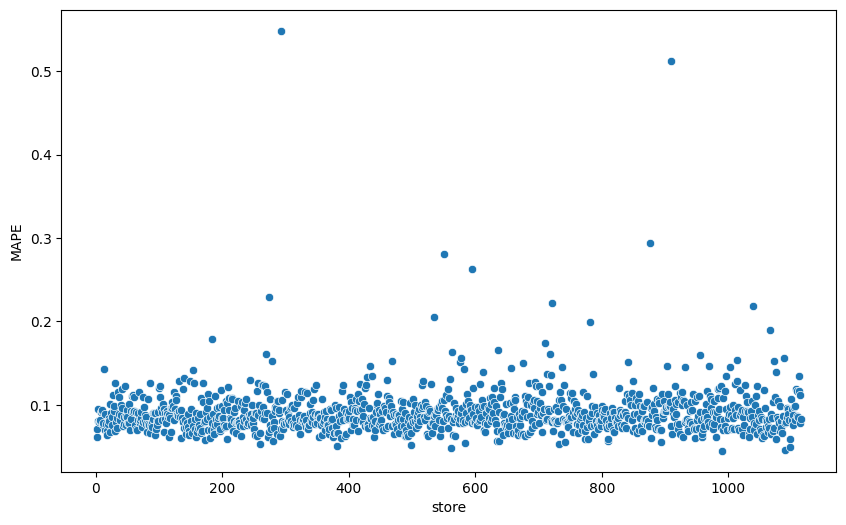

In [105]:
plt.figure( figsize=[10,6])
sns.scatterplot( x='store', y='MAPE', data=df92 )
print( 'A maioria das lojas tem o erro do predict de 10%' )

In [106]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104504.164062,101214.195557,107794.132568,3289.968506,0.548456
908,909,242845.046875,235385.404849,250304.688901,7459.642026,0.512344
875,876,203990.015625,200049.587625,207930.443625,3940.428000,0.294258
549,550,245483.515625,244047.555717,246919.475533,1435.959908,0.280874
594,595,388157.812500,384345.510412,391970.114588,3812.302088,0.263248


## 9.2. Total Performance 

In [107]:
# Valor total em todos os cenarios das proximas 6 semanas 
df93 = df92[[ 'predictions', 'worst_scenario', 'best_scenario' ]].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index':'scenario', 0:'values'} )
df93['values'] = df93['values'].map( 'R${:,.2f}'.format )
df93

,scenario,values
0,predictions,"R$282,322,016.00"
1,worst_scenario,"R$281,614,891.72"
2,best_scenario,"R$283,029,144.03"


## 9.3. Machine Learning Performance 

In [108]:
# criando colunas para axiliar a criar alguns graficos. 
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

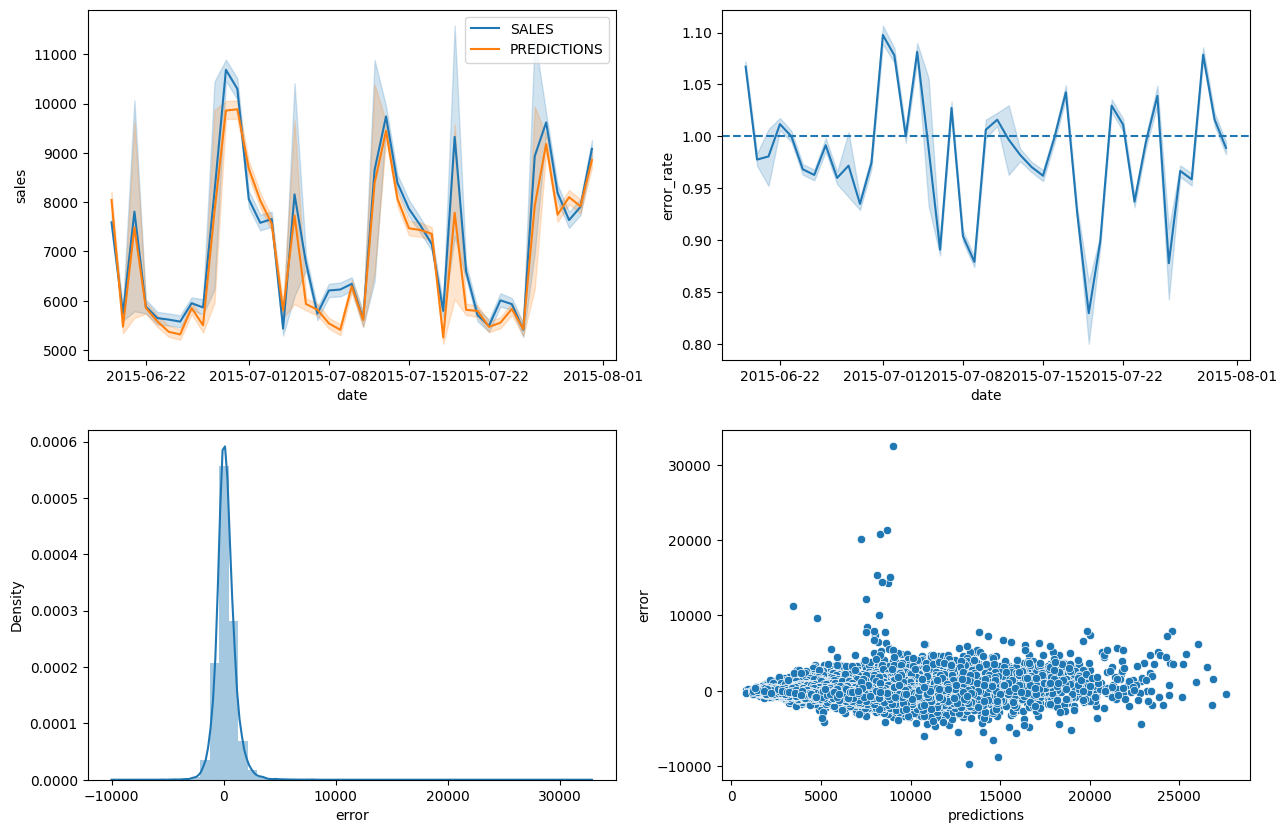

In [109]:
plt.figure( figsize=[15,10])

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
# uma linha que mostra o resultao perfeito do algoritimo.
# acima do 1 o algoritmo esta superestimando o algoritmo. 
# abaixo do 1 o algoritmo esta subestimado o algoritmo.
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df9  )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [110]:
#save training Model
pickle.dump( model_xgb_tuned, open( '/home/gustavo/Projects/CDS/DS_em_producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class 

In [111]:
import pickle
import inflection
import pandas as pd
import numpy  as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/gustavo/Projects/CDS/DS_em_producao/'
        self.competition_distance_scale =   pickle.dump( open( self.home_path + 'parameter/competition_distance_scale.pkl', 'rb' ))
        self.competition_time_month_scale = pickle.dump( open( self.home_path + 'parameter/competition_time_month_scale.pkl', 'rb' ) )
        self.promo_time_week__scale =       pickle.dump( open( self.home_path + 'parameter/promo_time_week__scale.pkl', 'rb' ))
        self.year_scale =                   pickle.dump( open( self.home_path + 'parameter/year_scale.pkl', 'rb' ) )
        self.store_type_scale =             pickle.dump( open( self.home_path + 'parameter/store_type_scale.pkl', 'rb' ))

    
    def data_cleaning( self, df1 ):
        # 1.1. Rename columns
        old_cols = [ 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear',
                    'PromoInterval' ]

        snakecase = lambda x: inflection.underscore( x )
        new_cols= list( map( snakecase, old_cols ) ) 
        #rename
        df1.columns = new_cols

        # 1.3. data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        # 1.5. Fillout NA
        #competition_distance    
        print(df1['competition_distance'].max()) 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

        #promo2_since_year 
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

        #promo_interval
        mouth_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }       

        df1['promo_interval'].fillna(0, inplace=True)
        
        df1['mouth_map'] = df1['date'].dt.month.map( mouth_map )
        df1['is_promo2'] = df1[['promo_interval', 'mouth_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['mouth_map'] in x['promo_interval'].split( ',' ) else 0 , axis=1)

        # 1.6. chage types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int ) 
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int ) 

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day 
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week 

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['conpetition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1 ), axis=1)
        df2['competition_time_month'] = ( ( df2['date'] - df2['conpetition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since 
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-W' + df2['promo2_since_week'].astype(str) + '-1'
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday 
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'  )


        # 3.1 Filtragem das linhas
        df2 = df2[ df2['open'] != 0 ]

        # 3.2. Seleção da colunas
        cols_drop = [ 'open', 'promo_interval', 'mouth_map']
        df2 = df2.drop( cols_drop, axis=1 )    

        return df2 
    
    def data_preparation( self, df5 ):
        # 5.2. Rescaling
        # competition_distance 
        df5['competition_distance'] = self.competition_distance_scale.fit_transform( df5[['competition_distance']].values )

        # competition_time_month.
        df5['competition_time_month'] = self.competition_time_month_scale.fit_transform( df5[['competition_time_month']].values )

        # promo_time_week.
        df5['promo_time_week'] = self.promo_time_week__scale.fit_transform( df5[['promo_time_week']].values )

        # year 
        df5['year'] = self.year_scale.fit_transform( df5[['year']].values )

        # 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, columns=['state_holiday'], dtype='uint8')

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scale.fit_transform( df5['store_type'] )    

        # assortment - Ordinal Encoding
        assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict ) 

        ### 5.3.3 Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) 
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) 

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) 

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) 
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) 
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) 

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                                'week_of_year_sin', 'week_of_year_cos']


        return df5[ cols_selected ] 
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [112]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load( open( '/home/gustavo/Projects/CDS/DS_em_producao/model/model_rossmann.pkl', 'rb' ) )

# initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=[ 'POST' ] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # Unique Example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # Multiple Example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    
        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction 
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [118]:
import requests

In [119]:
# loading test dataset
df10 = pd.read_csv( '/home/gustavo/Projects/CDS/DS_em_producao/datasets/test.csv' )

In [120]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )  

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [121]:
# Covert Dataframe to json 
import json
data = json.dumps(df_test.to_dict( orient='records' ))

In [122]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'http://172.19.233.174:5000/rossmann/predict'
#url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 500
